In [31]:
"""
Survue Object Detection Project
"""

# ============================================================================
# INSTALL DEPENDENCIES & IMPORTS
# ============================================================================

# Install required packages
import sys
!{sys.executable} -m pip install ultralytics pycocotools matplotlib seaborn

import json
import os
from pathlib import Path
import shutil
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import cv2
from pycocotools.coco import COCO
from collections import Counter, defaultdict
import pandas as pd
from PIL import Image

print("All packages installed successfully!")


[notice] A new release of pip is available: 25.0.1 -> 25.3
[notice] To update, run: pip install --upgrade pip
All packages installed successfully!


In [8]:


# ============================================================================
# SETUP PATHS
# ============================================================================

# Update these paths to match your Explorer Cluster setup
BASE_PATH = "/courses/CS5330.202610/data/FinalProject"
ANNOTATION_PATH = f"{BASE_PATH}/annotations"
IMAGES_PATH = f"{BASE_PATH}/images"

# Create working directory
WORK_DIR = Path("./survue_project")
WORK_DIR.mkdir(exist_ok=True)

# Create YOLO format directories
YOLO_DIR = WORK_DIR / "yolo_dataset"
YOLO_DIR.mkdir(exist_ok=True)

for split in ['train', 'val']:
    (YOLO_DIR / split / 'images').mkdir(parents=True, exist_ok=True)
    (YOLO_DIR / split / 'labels').mkdir(parents=True, exist_ok=True)

print(f"Working directory created at: {WORK_DIR}")

Working directory created at: survue_project



STEP 2: VISUALIZING SAMPLE ANNOTATIONS

  Visualizing sample annotations...

   Image: ti_munich_V008_2015jul_VIRB0008_7m_end_I00927.jpg
   Number of objects: 51
   Saved visualization to: survue_project/sample_viz_382.jpg


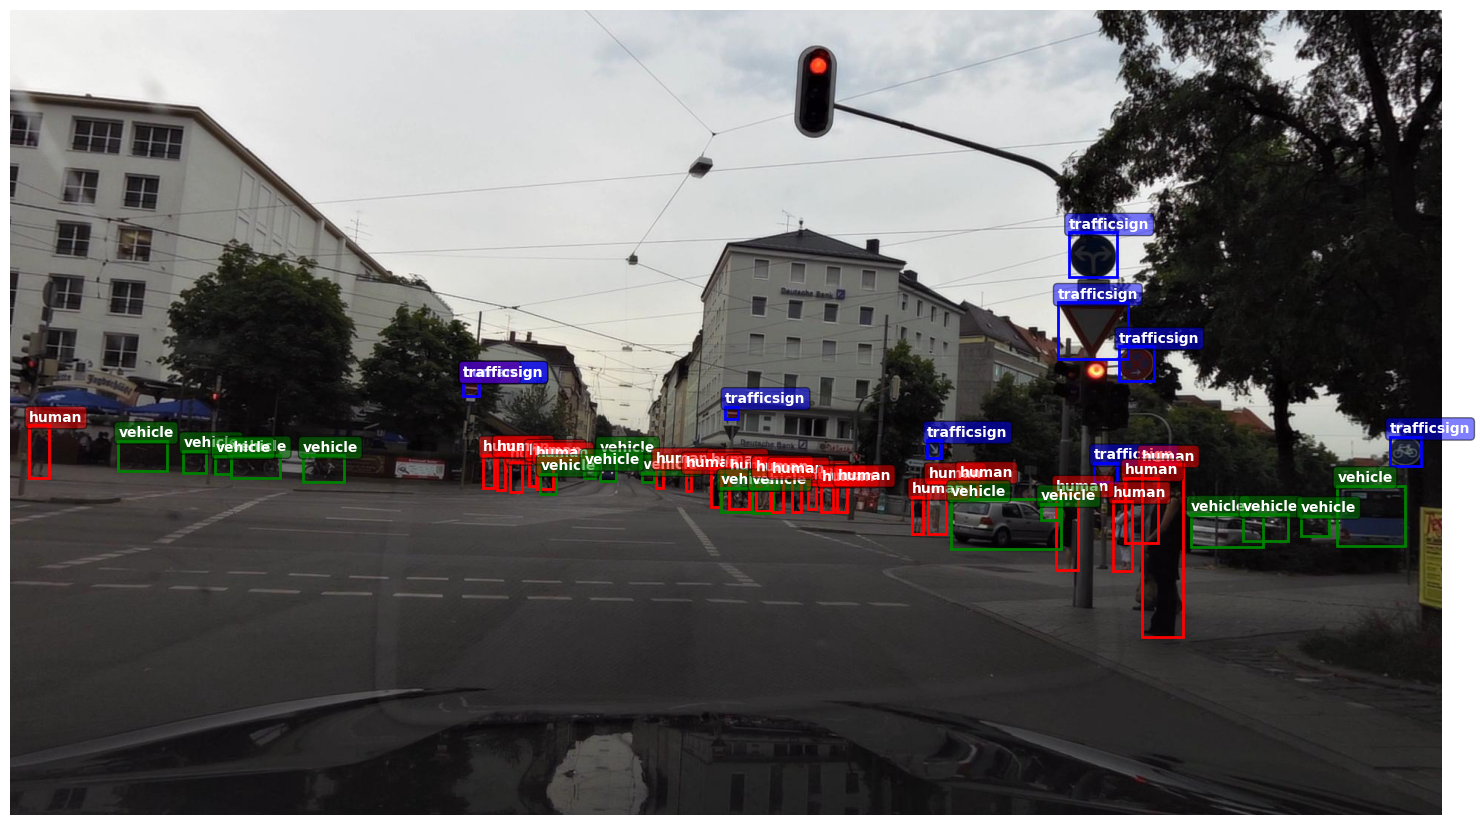


   Image: ti_lindau_V110_2015sept_103_VIRB_VIRB0001_I00805.jpg
   Number of objects: 22
   Saved visualization to: survue_project/sample_viz_211.jpg


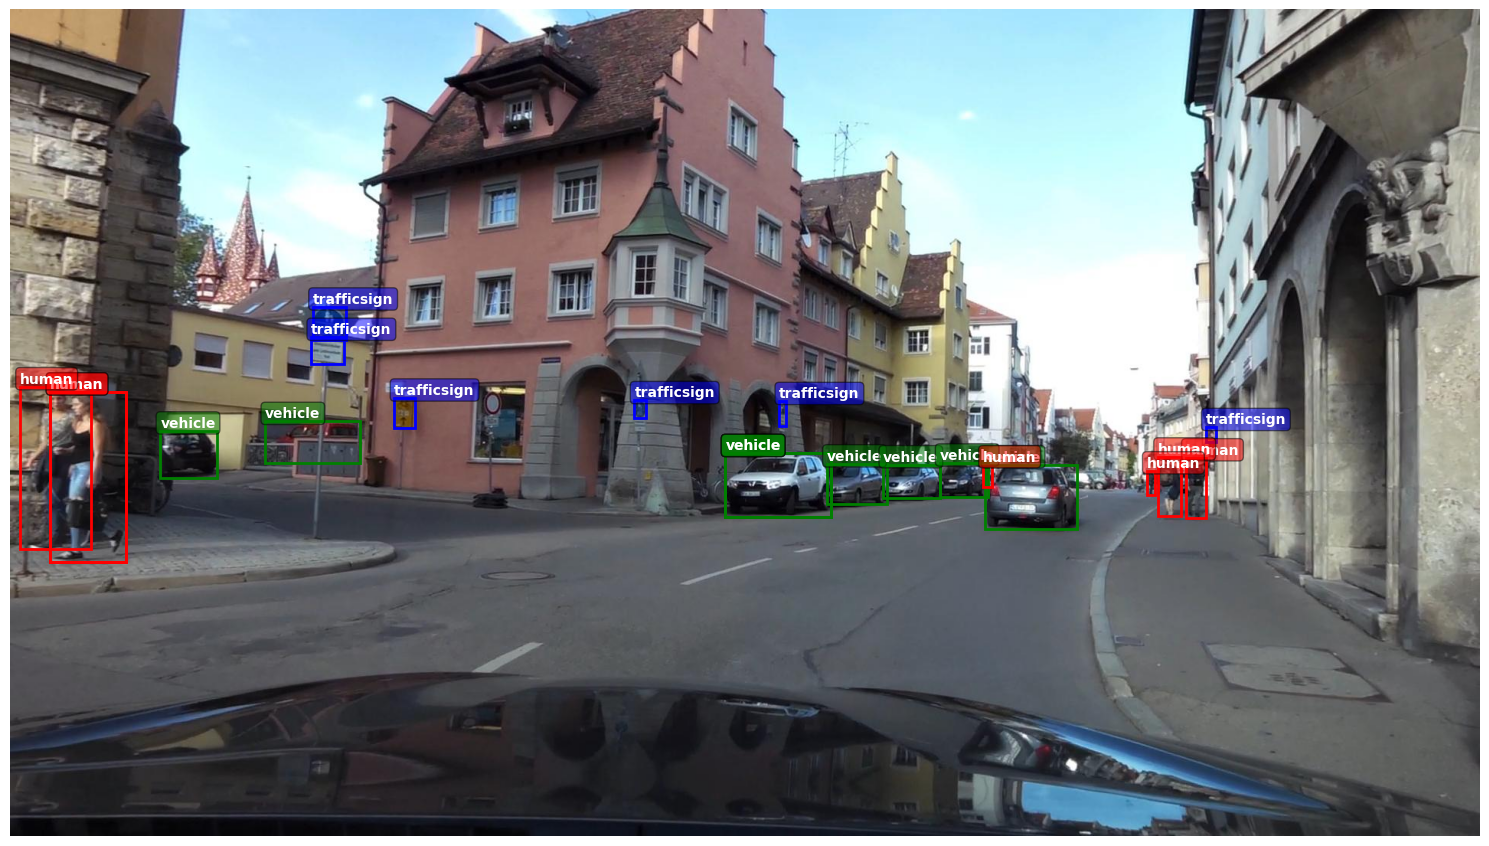


   Image: ti_lindau_V110_2015sept_103_VIRB_VIRB0001_I00925.jpg
   Number of objects: 20
   Saved visualization to: survue_project/sample_viz_206.jpg


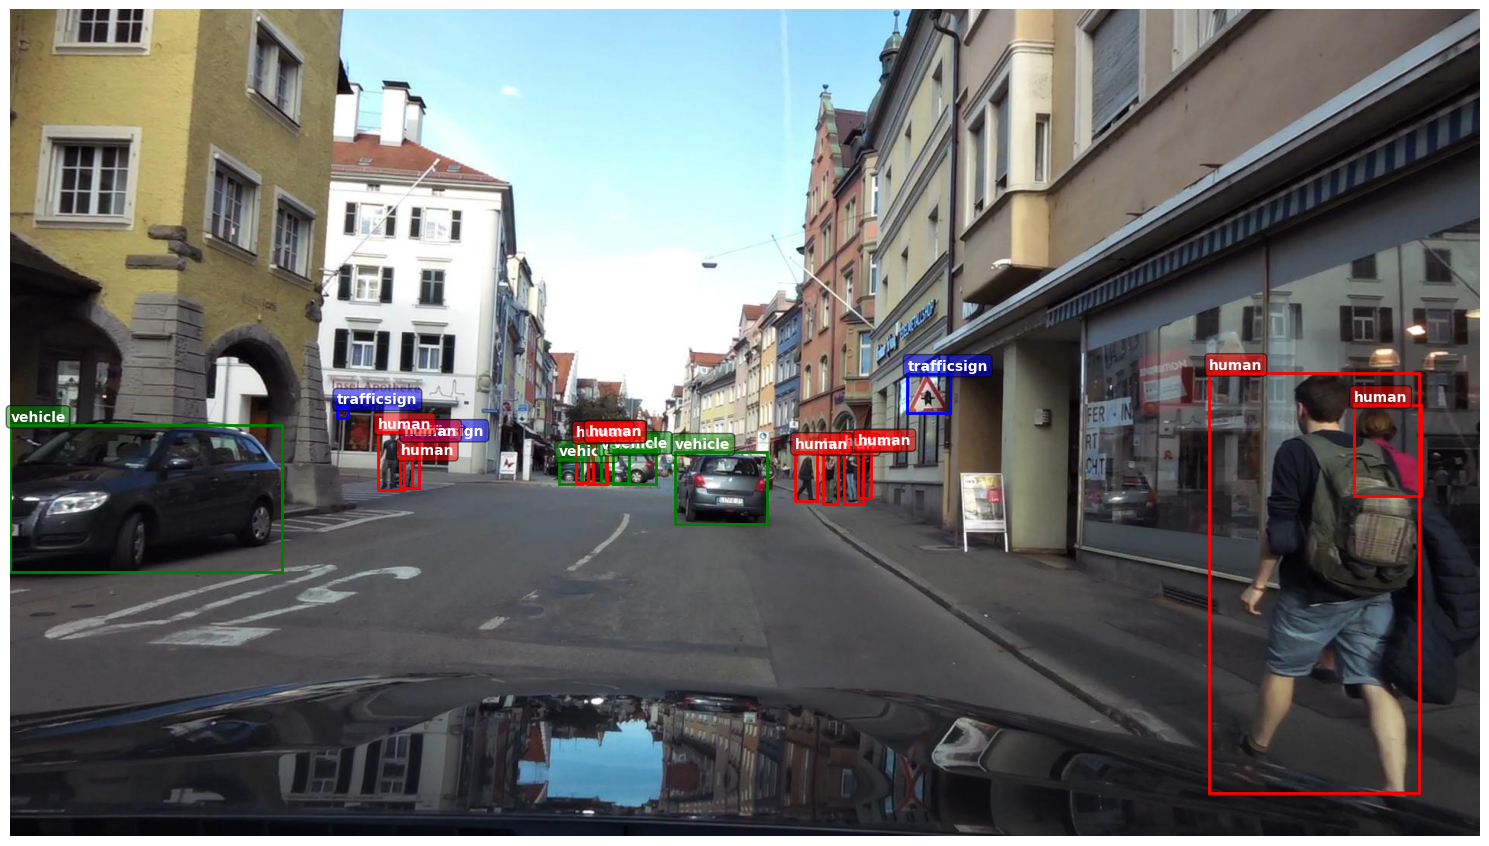

In [10]:
# ============================================================================
# VISUALIZE SAMPLE ANNOTATIONS
# ============================================================================

print("\n" + "="*70)
print("STEP 2: VISUALIZING SAMPLE ANNOTATIONS")
print("="*70)

def visualize_coco_annotations(image_path, annotations, categories, save_path=None):
    """Visualize COCO format annotations on an image"""
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    fig, ax = plt.subplots(1, figsize=(15, 10))
    ax.imshow(img)
    
    colors = {'human': 'red', 'trafficsign': 'blue', 'vehicle': 'green'}
    
    for ann in annotations:
        bbox = ann['bbox']  # [x, y, width, height]
        cat_id = ann['category_id']
        cat_name = next(c['name'] for c in categories if c['id'] == cat_id)
        color = colors.get(cat_name, 'yellow')
        
        rect = patches.Rectangle(
            (bbox[0], bbox[1]), bbox[2], bbox[3],
            linewidth=2, edgecolor=color, facecolor='none'
        )
        ax.add_patch(rect)
        
        # Add label
        ax.text(bbox[0], bbox[1]-5, cat_name, 
                bbox=dict(boxstyle='round', facecolor=color, alpha=0.5),
                fontsize=10, color='white', weight='bold')
    
    ax.axis('off')
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
        print(f"   Saved visualization to: {save_path}")
    
    plt.show()

# Visualize 3 random training samples
print("\n  Visualizing sample annotations...")
sample_indices = np.random.choice(len(train_images), min(3, len(train_images)), replace=False)

for idx in sample_indices:
    img_info = train_images[idx]
    img_id = img_info['id']
    img_filename = img_info['file_name']
    img_path = f"{IMAGES_PATH}/{img_filename}"
    
    # Get annotations for this image
    img_annotations = [ann for ann in train_annotations if ann['image_id'] == img_id]
    
    print(f"\n   Image: {img_filename}")
    print(f"   Number of objects: {len(img_annotations)}")
    
    if os.path.exists(img_path):
        save_path = WORK_DIR / f"sample_viz_{idx}.jpg"
        visualize_coco_annotations(img_path, img_annotations, categories, save_path)
    else:
        print(f"     Image not found at: {img_path}")



In [11]:
# ============================================================================
#  CONVERT COCO TO YOLO FORMAT
# ============================================================================

print("\n" + "="*70)
print("STEP 3: CONVERTING COCO FORMAT TO YOLO FORMAT")
print("="*70)

def convert_bbox_coco_to_yolo(bbox, img_width, img_height):
    """
    Convert COCO bbox [x, y, width, height] to YOLO format [x_center, y_center, width, height]
    All normalized to [0, 1]
    """
    x, y, w, h = bbox
    x_center = (x + w / 2) / img_width
    y_center = (y + h / 2) / img_height
    w_norm = w / img_width
    h_norm = h / img_height
    return [x_center, y_center, w_norm, h_norm]

def convert_coco_to_yolo(coco_data, split_name, images_src_path, yolo_dir):
    """Convert COCO format to YOLO format"""
    images = coco_data['images']
    annotations = coco_data['annotations']
    categories = coco_data['categories']
    
    # Create category_id to class_index mapping (YOLO uses 0-indexed classes)
    cat_id_to_idx = {cat['id']: idx for idx, cat in enumerate(categories)}
    
    # Group annotations by image_id
    img_to_anns = {}
    for ann in annotations:
        img_id = ann['image_id']
        if img_id not in img_to_anns:
            img_to_anns[img_id] = []
        img_to_anns[img_id].append(ann)
    
    converted_count = 0
    
    for img_info in images:
        img_id = img_info['id']
        img_filename = img_info['file_name']
        img_width = img_info['width']
        img_height = img_info['height']
        
        src_img_path = f"{images_src_path}/{img_filename}"
        
        # Skip if image doesn't exist
        if not os.path.exists(src_img_path):
            continue
        
        # Copy image to YOLO directory
        dst_img_path = yolo_dir / split_name / 'images' / img_filename
        shutil.copy2(src_img_path, dst_img_path)
        
        # Create YOLO format label file
        label_filename = Path(img_filename).stem + '.txt'
        label_path = yolo_dir / split_name / 'labels' / label_filename
        
        # Get annotations for this image
        img_anns = img_to_anns.get(img_id, [])
        
        with open(label_path, 'w') as f:
            for ann in img_anns:
                cat_id = ann['category_id']
                class_idx = cat_id_to_idx[cat_id]
                bbox_coco = ann['bbox']
                bbox_yolo = convert_bbox_coco_to_yolo(bbox_coco, img_width, img_height)
                
                # Write in YOLO format: class_idx x_center y_center width height
                f.write(f"{class_idx} {' '.join([f'{v:.6f}' for v in bbox_yolo])}\n")
        
        converted_count += 1
    
    return converted_count

# Convert training data
print("\n Converting training data...")
train_converted = convert_coco_to_yolo(train_data, 'train', IMAGES_PATH, YOLO_DIR)
print(f"   Converted {train_converted} training images")

# Convert validation data
print("\n Converting validation data...")
val_converted = convert_coco_to_yolo(val_data, 'val', IMAGES_PATH, YOLO_DIR)
print(f"    Converted {val_converted} validation images")




STEP 3: CONVERTING COCO FORMAT TO YOLO FORMAT

 Converting training data...
   Converted 393 training images

 Converting validation data...
    Converted 107 validation images


Data loaded successfully!
Training: 393 images, 8092 annotations
Validation: 107 images, 1695 annotations
 Saved: class_distribution.png


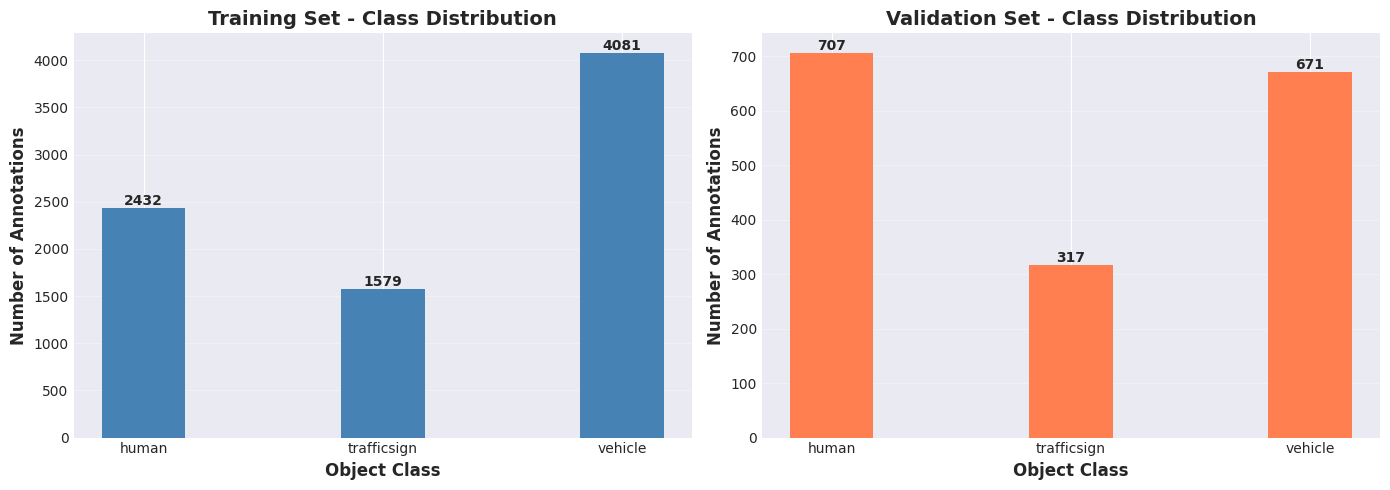


Class Distribution Percentages:

Training Set:
  human: 2432 (30.1%)
  trafficsign: 1579 (19.5%)
  vehicle: 4081 (50.4%)

Validation Set:
  human: 707 (41.7%)
  trafficsign: 317 (18.7%)
  vehicle: 671 (39.6%)
 Saved: bbox_size_distribution.png


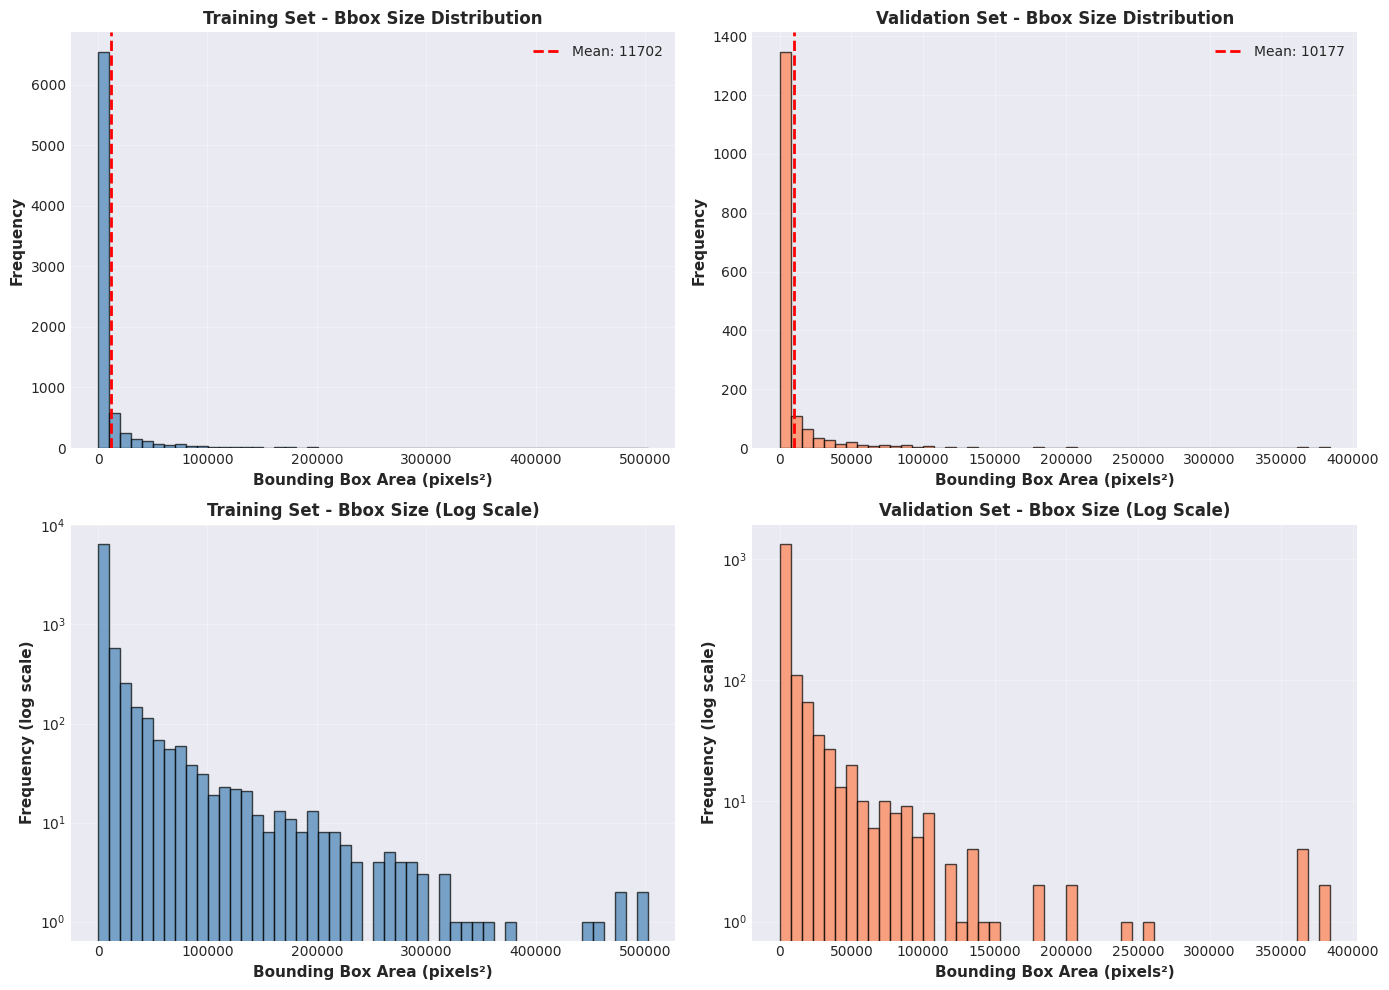


Bounding Box Area Statistics:

Training Set:
  Mean: 11702 pixels²
  Median: 1776 pixels²
  Std Dev: 33743 pixels²
  Min: 28 pixels²
  Max: 502752 pixels²

Validation Set:
  Mean: 10177 pixels²
  Median: 1522 pixels²
  Std Dev: 31113 pixels²
  Min: 9 pixels²
  Max: 383770 pixels²
✓ Saved: size_categories.png


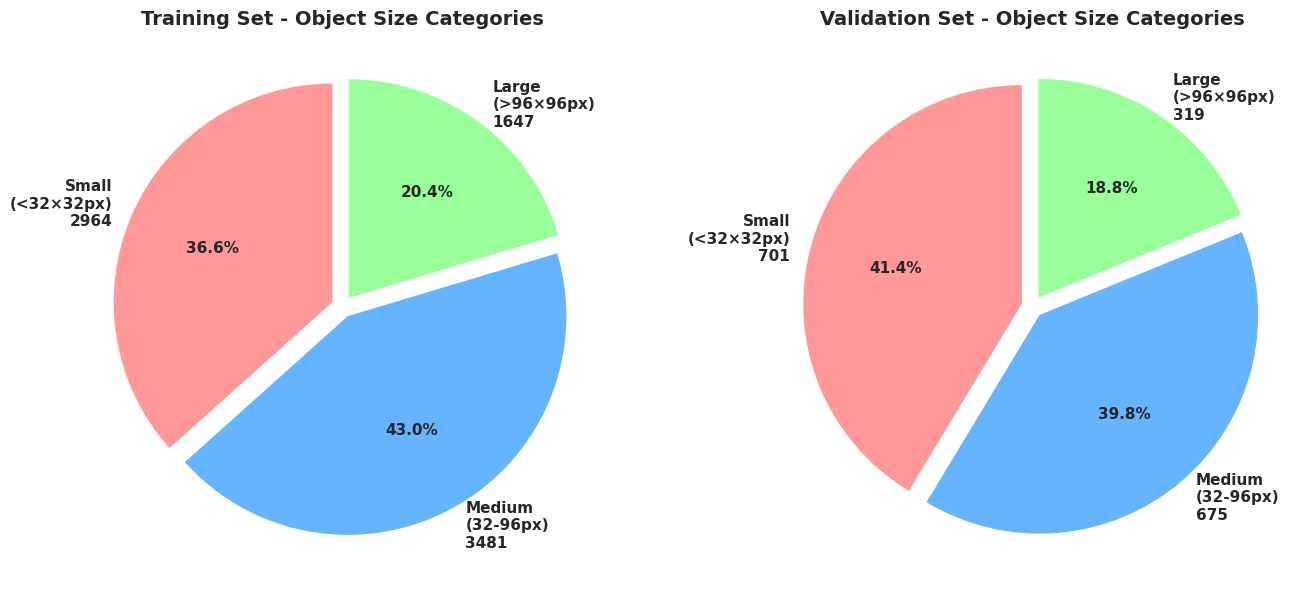


Object Size Categories:

Training Set:
  Small (<32×32): 2964 (36.6%)
  Medium (32-96): 3481 (43.0%)
  Large (>96×96): 1647 (20.4%)

Validation Set:
  Small (<32×32): 701 (41.4%)
  Medium (32-96): 675 (39.8%)
  Large (>96×96): 319 (18.8%)
✓ Saved: aspect_ratios.png


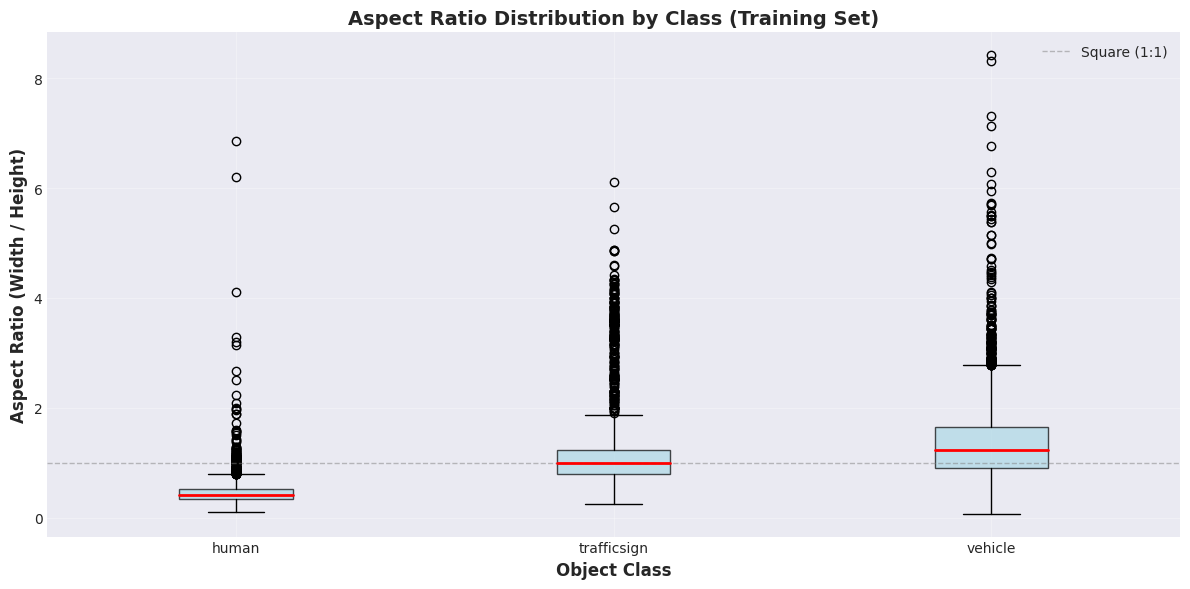


Aspect Ratio Statistics (Width/Height):

human:
  Mean: 0.47
  Median: 0.41
  Interpretation: Tall objects

trafficsign:
  Mean: 1.28
  Median: 1.00
  Interpretation: Roughly square

vehicle:
  Mean: 1.35
  Median: 1.24
  Interpretation: Roughly square
✓ Saved: objects_per_image.png


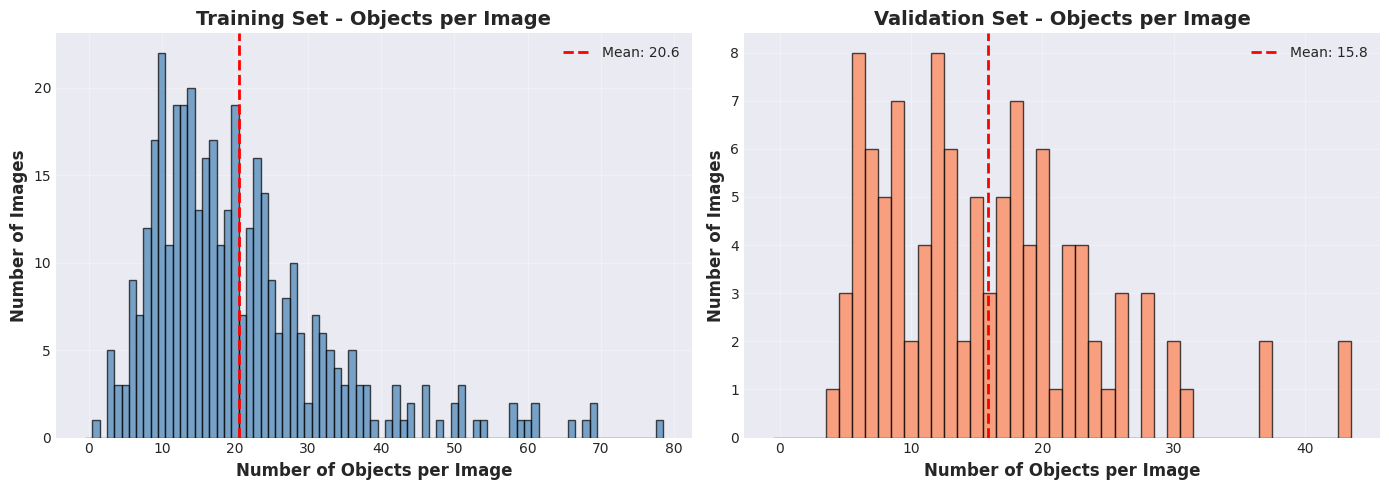


Objects per Image Statistics:

Training Set:
  Mean: 20.6 objects/image
  Median: 18 objects/image
  Min: 1 objects/image
  Max: 78 objects/image

Validation Set:
  Mean: 15.8 objects/image
  Median: 15 objects/image
  Min: 4 objects/image
  Max: 43 objects/image

DATASET SUMMARY - COMPLETE STATISTICS

METRIC                                   TRAINING        VALIDATION     
----------------------------------------------------------------------
Number of Images                         393             107            
Number of Annotations                    8092            1695           
Avg Annotations per Image                20.59           15.84          
Avg Bbox Area (pixels²)                  11702           10177          
Median Bbox Area (pixels²)               1776            1522           

All visualizations saved to: survue_project/visualizations

 visualizations generated successfully!


In [19]:


# Set style plots
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# ============================================================================
# LOAD DATA
# ============================================================================

#  paths
ANNOTATION_PATH = "/courses/CS5330.202610/data/FinalProject/annotations"
OUTPUT_DIR = Path("./survue_project/visualizations")
OUTPUT_DIR.mkdir(exist_ok=True)

# Load annotations
with open(f"{ANNOTATION_PATH}/instances_train.json", 'r') as f:
    train_data = json.load(f)

with open(f"{ANNOTATION_PATH}/instances_val.json", 'r') as f:
    val_data = json.load(f)

categories = train_data['categories']
train_images = train_data['images']
val_images = val_data['images']
train_annotations = train_data['annotations']
val_annotations = val_data['annotations']

print("Data loaded successfully!")
print(f"Training: {len(train_images)} images, {len(train_annotations)} annotations")
print(f"Validation: {len(val_images)} images, {len(val_annotations)} annotations")

# ============================================================================
# 1. CLASS DISTRIBUTION BAR CHART
# ============================================================================

def plot_class_distribution():
    """Bar chart showing annotation counts per class"""
    
    # Count annotations per class
    train_counts = Counter([ann['category_id'] for ann in train_annotations])
    val_counts = Counter([ann['category_id'] for ann in val_annotations])
    
    # Get class names
    class_names = [cat['name'] for cat in sorted(categories, key=lambda x: x['id'])]
    class_ids = [cat['id'] for cat in sorted(categories, key=lambda x: x['id'])]
    
    train_values = [train_counts[cid] for cid in class_ids]
    val_values = [val_counts[cid] for cid in class_ids]
    
    # Create figure
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
    
    x = np.arange(len(class_names))
    width = 0.35
    
    # Training set
    bars1 = ax1.bar(x, train_values, width, label='Training', color='steelblue')
    ax1.set_xlabel('Object Class', fontsize=12, fontweight='bold')
    ax1.set_ylabel('Number of Annotations', fontsize=12, fontweight='bold')
    ax1.set_title('Training Set - Class Distribution', fontsize=14, fontweight='bold')
    ax1.set_xticks(x)
    ax1.set_xticklabels(class_names)
    ax1.grid(axis='y', alpha=0.3)
    
    # Add value labels on bars
    for bar in bars1:
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height,
                f'{int(height)}',
                ha='center', va='bottom', fontweight='bold')
    
    # Validation set
    bars2 = ax2.bar(x, val_values, width, label='Validation', color='coral')
    ax2.set_xlabel('Object Class', fontsize=12, fontweight='bold')
    ax2.set_ylabel('Number of Annotations', fontsize=12, fontweight='bold')
    ax2.set_title('Validation Set - Class Distribution', fontsize=14, fontweight='bold')
    ax2.set_xticks(x)
    ax2.set_xticklabels(class_names)
    ax2.grid(axis='y', alpha=0.3)
    
    # Add value labels on bars
    for bar in bars2:
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height,
                f'{int(height)}',
                ha='center', va='bottom', fontweight='bold')
    
    plt.tight_layout()
    plt.savefig(OUTPUT_DIR / 'class_distribution.png', dpi=300, bbox_inches='tight')
    print(f" Saved: class_distribution.png")
    plt.show()
    
    # Print percentages
    print("\nClass Distribution Percentages:")
    print("\nTraining Set:")
    total_train = sum(train_values)
    for name, count in zip(class_names, train_values):
        pct = (count / total_train) * 100
        print(f"  {name}: {count} ({pct:.1f}%)")
    
    print("\nValidation Set:")
    total_val = sum(val_values)
    for name, count in zip(class_names, val_values):
        pct = (count / total_val) * 100
        print(f"  {name}: {count} ({pct:.1f}%)")

plot_class_distribution()

# ============================================================================
# 2. BOUNDING BOX SIZE DISTRIBUTION
# ============================================================================

def plot_bbox_size_distribution():
    """Histogram of bounding box sizes (area in pixels)"""
    
    # Extract bbox areas
    train_areas = [ann['bbox'][2] * ann['bbox'][3] for ann in train_annotations]
    val_areas = [ann['bbox'][2] * ann['bbox'][3] for ann in val_annotations]
    
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    # Training histogram
    axes[0, 0].hist(train_areas, bins=50, color='steelblue', alpha=0.7, edgecolor='black')
    axes[0, 0].set_xlabel('Bounding Box Area (pixels²)', fontsize=11, fontweight='bold')
    axes[0, 0].set_ylabel('Frequency', fontsize=11, fontweight='bold')
    axes[0, 0].set_title('Training Set - Bbox Size Distribution', fontsize=12, fontweight='bold')
    axes[0, 0].grid(alpha=0.3)
    axes[0, 0].axvline(np.mean(train_areas), color='red', linestyle='--', linewidth=2, label=f'Mean: {np.mean(train_areas):.0f}')
    axes[0, 0].legend()
    
    # Validation histogram
    axes[0, 1].hist(val_areas, bins=50, color='coral', alpha=0.7, edgecolor='black')
    axes[0, 1].set_xlabel('Bounding Box Area (pixels²)', fontsize=11, fontweight='bold')
    axes[0, 1].set_ylabel('Frequency', fontsize=11, fontweight='bold')
    axes[0, 1].set_title('Validation Set - Bbox Size Distribution', fontsize=12, fontweight='bold')
    axes[0, 1].grid(alpha=0.3)
    axes[0, 1].axvline(np.mean(val_areas), color='red', linestyle='--', linewidth=2, label=f'Mean: {np.mean(val_areas):.0f}')
    axes[0, 1].legend()
    
    # Log scale histogram (better for wide range)
    axes[1, 0].hist(train_areas, bins=50, color='steelblue', alpha=0.7, edgecolor='black')
    axes[1, 0].set_xlabel('Bounding Box Area (pixels²)', fontsize=11, fontweight='bold')
    axes[1, 0].set_ylabel('Frequency (log scale)', fontsize=11, fontweight='bold')
    axes[1, 0].set_title('Training Set - Bbox Size (Log Scale)', fontsize=12, fontweight='bold')
    axes[1, 0].set_yscale('log')
    axes[1, 0].grid(alpha=0.3)
    
    axes[1, 1].hist(val_areas, bins=50, color='coral', alpha=0.7, edgecolor='black')
    axes[1, 1].set_xlabel('Bounding Box Area (pixels²)', fontsize=11, fontweight='bold')
    axes[1, 1].set_ylabel('Frequency (log scale)', fontsize=11, fontweight='bold')
    axes[1, 1].set_title('Validation Set - Bbox Size (Log Scale)', fontsize=12, fontweight='bold')
    axes[1, 1].set_yscale('log')
    axes[1, 1].grid(alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(OUTPUT_DIR / 'bbox_size_distribution.png', dpi=300, bbox_inches='tight')
    print(f" Saved: bbox_size_distribution.png")
    plt.show()
    
    # Print statistics
    print("\nBounding Box Area Statistics:")
    print(f"\nTraining Set:")
    print(f"  Mean: {np.mean(train_areas):.0f} pixels²")
    print(f"  Median: {np.median(train_areas):.0f} pixels²")
    print(f"  Std Dev: {np.std(train_areas):.0f} pixels²")
    print(f"  Min: {np.min(train_areas):.0f} pixels²")
    print(f"  Max: {np.max(train_areas):.0f} pixels²")
    
    print(f"\nValidation Set:")
    print(f"  Mean: {np.mean(val_areas):.0f} pixels²")
    print(f"  Median: {np.median(val_areas):.0f} pixels²")
    print(f"  Std Dev: {np.std(val_areas):.0f} pixels²")
    print(f"  Min: {np.min(val_areas):.0f} pixels²")
    print(f"  Max: {np.max(val_areas):.0f} pixels²")

plot_bbox_size_distribution()

# ============================================================================
# 3. OBJECT SIZE CATEGORIES
# ============================================================================

def plot_size_categories():
    """Categorize objects as small/medium/large"""
    
    # Define size thresholds (COCO standard)
    SMALL_THRESHOLD = 32 * 32  # 1024 pixels²
    MEDIUM_THRESHOLD = 96 * 96  # 9216 pixels²
    
    def categorize_sizes(annotations):
        small, medium, large = 0, 0, 0
        for ann in annotations:
            area = ann['bbox'][2] * ann['bbox'][3]
            if area < SMALL_THRESHOLD:
                small += 1
            elif area < MEDIUM_THRESHOLD:
                medium += 1
            else:
                large += 1
        return small, medium, large
    
    train_small, train_medium, train_large = categorize_sizes(train_annotations)
    val_small, val_medium, val_large = categorize_sizes(val_annotations)
    
    # Create pie charts
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
    
    # Training set
    sizes = [train_small, train_medium, train_large]
    labels = [f'Small\n(<32×32px)\n{train_small}', 
              f'Medium\n(32-96px)\n{train_medium}', 
              f'Large\n(>96×96px)\n{train_large}']
    colors = ['#ff9999', '#66b3ff', '#99ff99']
    explode = (0.05, 0.05, 0.05)
    
    ax1.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%',
            startangle=90, explode=explode, textprops={'fontsize': 11, 'fontweight': 'bold'})
    ax1.set_title('Training Set - Object Size Categories', fontsize=14, fontweight='bold')
    
    # Validation set
    sizes_val = [val_small, val_medium, val_large]
    labels_val = [f'Small\n(<32×32px)\n{val_small}', 
                  f'Medium\n(32-96px)\n{val_medium}', 
                  f'Large\n(>96×96px)\n{val_large}']
    
    ax2.pie(sizes_val, labels=labels_val, colors=colors, autopct='%1.1f%%',
            startangle=90, explode=explode, textprops={'fontsize': 11, 'fontweight': 'bold'})
    ax2.set_title('Validation Set - Object Size Categories', fontsize=14, fontweight='bold')
    
    plt.tight_layout()
    plt.savefig(OUTPUT_DIR / 'size_categories.png', dpi=300, bbox_inches='tight')
    print(f"✓ Saved: size_categories.png")
    plt.show()
    
    # Print percentages
    total_train = len(train_annotations)
    total_val = len(val_annotations)
    
    print("\nObject Size Categories:")
    print(f"\nTraining Set:")
    print(f"  Small (<32×32): {train_small} ({train_small/total_train*100:.1f}%)")
    print(f"  Medium (32-96): {train_medium} ({train_medium/total_train*100:.1f}%)")
    print(f"  Large (>96×96): {train_large} ({train_large/total_train*100:.1f}%)")
    
    print(f"\nValidation Set:")
    print(f"  Small (<32×32): {val_small} ({val_small/total_val*100:.1f}%)")
    print(f"  Medium (32-96): {val_medium} ({val_medium/total_val*100:.1f}%)")
    print(f"  Large (>96×96): {val_large} ({val_large/total_val*100:.1f}%)")

plot_size_categories()

# ============================================================================
# 4. ASPECT RATIO DISTRIBUTION
# ============================================================================

def plot_aspect_ratios():
    """Analyze width/height ratios by class"""
    
    # Calculate aspect ratios per class
    class_ratios = {cat['id']: [] for cat in categories}
    
    for ann in train_annotations:
        width = ann['bbox'][2]
        height = ann['bbox'][3]
        if height > 0:  # Avoid division by zero
            ratio = width / height
            class_ratios[ann['category_id']].append(ratio)
    
    # Create box plots
    fig, ax = plt.subplots(figsize=(12, 6))
    
    class_names = [cat['name'] for cat in sorted(categories, key=lambda x: x['id'])]
    class_ids = [cat['id'] for cat in sorted(categories, key=lambda x: x['id'])]
    
    data_to_plot = [class_ratios[cid] for cid in class_ids]
    
    bp = ax.boxplot(data_to_plot, labels=class_names, patch_artist=True,
                    medianprops=dict(color='red', linewidth=2),
                    boxprops=dict(facecolor='lightblue', alpha=0.7))
    
    ax.set_xlabel('Object Class', fontsize=12, fontweight='bold')
    ax.set_ylabel('Aspect Ratio (Width / Height)', fontsize=12, fontweight='bold')
    ax.set_title('Aspect Ratio Distribution by Class (Training Set)', fontsize=14, fontweight='bold')
    ax.axhline(y=1.0, color='gray', linestyle='--', linewidth=1, alpha=0.5, label='Square (1:1)')
    ax.grid(alpha=0.3)
    ax.legend()
    
    plt.tight_layout()
    plt.savefig(OUTPUT_DIR / 'aspect_ratios.png', dpi=300, bbox_inches='tight')
    print(f"✓ Saved: aspect_ratios.png")
    plt.show()
    
    # Print statistics
    print("\nAspect Ratio Statistics (Width/Height):")
    for name, cid in zip(class_names, class_ids):
        ratios = class_ratios[cid]
        if ratios:
            print(f"\n{name}:")
            print(f"  Mean: {np.mean(ratios):.2f}")
            print(f"  Median: {np.median(ratios):.2f}")
            print(f"  Interpretation: {'Wide objects' if np.mean(ratios) > 1.5 else 'Tall objects' if np.mean(ratios) < 0.7 else 'Roughly square'}")

plot_aspect_ratios()

# ============================================================================
# 5. ANNOTATIONS PER IMAGE
# ============================================================================

def plot_annotations_per_image():
    """Histogram of how many objects per image"""
    
    # Count annotations per image
    train_img_counts = Counter([ann['image_id'] for ann in train_annotations])
    val_img_counts = Counter([ann['image_id'] for ann in val_annotations])
    
    train_counts = list(train_img_counts.values())
    val_counts = list(val_img_counts.values())
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
    
    # Training set
    ax1.hist(train_counts, bins=range(0, max(train_counts)+2), color='steelblue', 
             alpha=0.7, edgecolor='black', align='left')
    ax1.set_xlabel('Number of Objects per Image', fontsize=12, fontweight='bold')
    ax1.set_ylabel('Number of Images', fontsize=12, fontweight='bold')
    ax1.set_title('Training Set - Objects per Image', fontsize=14, fontweight='bold')
    ax1.axvline(np.mean(train_counts), color='red', linestyle='--', linewidth=2, 
                label=f'Mean: {np.mean(train_counts):.1f}')
    ax1.grid(alpha=0.3)
    ax1.legend()
    
    # Validation set
    ax2.hist(val_counts, bins=range(0, max(val_counts)+2), color='coral', 
             alpha=0.7, edgecolor='black', align='left')
    ax2.set_xlabel('Number of Objects per Image', fontsize=12, fontweight='bold')
    ax2.set_ylabel('Number of Images', fontsize=12, fontweight='bold')
    ax2.set_title('Validation Set - Objects per Image', fontsize=14, fontweight='bold')
    ax2.axvline(np.mean(val_counts), color='red', linestyle='--', linewidth=2, 
                label=f'Mean: {np.mean(val_counts):.1f}')
    ax2.grid(alpha=0.3)
    ax2.legend()
    
    plt.tight_layout()
    plt.savefig(OUTPUT_DIR / 'objects_per_image.png', dpi=300, bbox_inches='tight')
    print(f"✓ Saved: objects_per_image.png")
    plt.show()
    
    # Print statistics
    print("\nObjects per Image Statistics:")
    print(f"\nTraining Set:")
    print(f"  Mean: {np.mean(train_counts):.1f} objects/image")
    print(f"  Median: {np.median(train_counts):.0f} objects/image")
    print(f"  Min: {np.min(train_counts)} objects/image")
    print(f"  Max: {np.max(train_counts)} objects/image")
    
    print(f"\nValidation Set:")
    print(f"  Mean: {np.mean(val_counts):.1f} objects/image")
    print(f"  Median: {np.median(val_counts):.0f} objects/image")
    print(f"  Min: {np.min(val_counts)} objects/image")
    print(f"  Max: {np.max(val_counts)} objects/image")

plot_annotations_per_image()

# ============================================================================
# 6. COMPREHENSIVE SUMMARY TABLE
# ============================================================================

def print_summary_table():
    """Print comprehensive dataset statistics"""
    
    print("\n" + "="*70)
    print("DATASET SUMMARY - COMPLETE STATISTICS")
    print("="*70)
    
    print(f"\n{'METRIC':<40} {'TRAINING':<15} {'VALIDATION':<15}")
    print("-" * 70)
    
    # Basic counts
    print(f"{'Number of Images':<40} {len(train_images):<15} {len(val_images):<15}")
    print(f"{'Number of Annotations':<40} {len(train_annotations):<15} {len(val_annotations):<15}")
    
    # Average annotations per image
    train_avg = len(train_annotations) / len(train_images)
    val_avg = len(val_annotations) / len(val_images)
    print(f"{'Avg Annotations per Image':<40} {train_avg:<15.2f} {val_avg:<15.2f}")
    
    # Bbox area statistics
    train_areas = [ann['bbox'][2] * ann['bbox'][3] for ann in train_annotations]
    val_areas = [ann['bbox'][2] * ann['bbox'][3] for ann in val_annotations]
    
    print(f"{'Avg Bbox Area (pixels²)':<40} {np.mean(train_areas):<15.0f} {np.mean(val_areas):<15.0f}")
    print(f"{'Median Bbox Area (pixels²)':<40} {np.median(train_areas):<15.0f} {np.median(val_areas):<15.0f}")
    
    print("\n" + "="*70)
    print("All visualizations saved to:", OUTPUT_DIR)
    print("="*70)

print_summary_table()

print("\n visualizations generated successfully!")


In [12]:
# ============================================================================
#  CREATE YOLO DATASET CONFIG
# ============================================================================

print("\n" + "="*70)
print("STEP 4: CREATING YOLO DATASET CONFIGURATION")
print("="*70)

# Create dataset.yaml
dataset_yaml_content = f"""# Survue Object Detection Dataset
path: {YOLO_DIR.absolute()}
train: train/images
val: val/images

# Classes
nc: 3  # number of classes
names: ['human', 'trafficsign', 'vehicle']
"""

yaml_path = YOLO_DIR / 'dataset.yaml'
with open(yaml_path, 'w') as f:
    f.write(dataset_yaml_content)

print(f"Dataset configuration saved to: {yaml_path}")
print("\n Dataset.yaml content:")
print(dataset_yaml_content)

# ============================================================================
#  TRAIN YOLO MODELS
# ============================================================================

print("\n" + "="*70)
print("STEP 5: TRAINING YOLO MODELS")
print("="*70)

from ultralytics import YOLO

# Train YOLOv8 Nano (lightweight)
print("\n Training YOLOv8 Nano (lightweight model)...")
print(" Starting training...")

model_nano = YOLO('yolov8n.pt')  # Load pretrained nano model

# Train the model
results_nano = model_nano.train(
    data=str(yaml_path),
    epochs=10,
    imgsz=640,
    batch=16,
    name='survue_yolov8n',
    patience=5,  
    save=True,
    plots=True,
    device='cpu'  # Use GPU if available, else CPU
)

print("YOLOv8 Nano training complete!")
print(f"   Results saved to: runs/detect/survue_yolov8n")




STEP 4: CREATING YOLO DATASET CONFIGURATION
Dataset configuration saved to: survue_project/yolo_dataset/dataset.yaml

 Dataset.yaml content:
# Survue Object Detection Dataset
path: /home/yarramasu.p/survue_project/yolo_dataset
train: train/images
val: val/images

# Classes
nc: 3  # number of classes
names: ['human', 'trafficsign', 'vehicle']


STEP 5: TRAINING YOLO MODELS

 Training YOLOv8 Nano (lightweight model)...
 Starting training...
New https://pypi.org/project/ultralytics/8.3.235 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.234 🚀 Python-3.10.16 torch-2.5.1 CPU (Intel Xeon CPU E5-2680 v4 @ 2.40GHz)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=survue_project/yolo_dataset/dataset.yaml, degrees=0.0, deterministic=True, device=cpu, dfl

In [ ]:
from ultralytics import YOLO
yaml_path = YOLO_DIR / 'dataset.yaml'


# Train YOLOv8 nano (better accuracy)
print("\n Training YOLOv8 nano (better accuracy)...")

model_nano = YOLO('yolov8s.pt')  # Load pretrained small model

results_small = model_nano.train(
    data=str(yaml_path),
    epochs=25,
    imgsz=640,
    batch=16,
    name='survue_yolov8n',
    patience=10,  
    save=True,
    plots=True,
    device='cpu'
    
)

print("YOLOv8 nano training complete!")
print(f"   Results saved to: runs/detect/survue_yolov8n")




 Training YOLOv8 nano (better accuracy)...
New https://pypi.org/project/ultralytics/8.3.235 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.234 🚀 Python-3.10.16 torch-2.5.1 CPU (Intel Xeon CPU E5-2680 v4 @ 2.40GHz)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=survue_project/yolo_dataset/dataset.yaml, degrees=0.0, deterministic=True, device=cpu, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=10, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8s.pt, momentum=0.937, mosaic=1.

In [ ]:


# Train YOLOv8 Small (better accuracy)
print("\n Training YOLOv8 Small (better accuracy)...")

model_small = YOLO('yolov8s.pt')  # Load pretrained small model

results_small = model_small.train(
    data=str(yaml_path),
    epochs=25,
    imgsz=640,
    batch=16,
    name='survue_yolov8s',
    patience=10,
    save=True,
    plots=True,
    device='cpu'
)

print("YOLOv8 Small training complete!")
print(f"   Results saved to: runs/detect/survue_yolov8s")



In [18]:
# Resume training with NEW epoch count
model_small_resume = YOLO('runs/detect/survue_yolov8s/weights/last.pt')

results_small_continued = model_small_resume.train(
    data=str(yaml_path),  
    epochs=20,  # 20 more epochs
    resume=False  
)

New https://pypi.org/project/ultralytics/8.3.235 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.234 🚀 Python-3.10.16 torch-2.5.1 CPU (Intel Xeon CPU E5-2680 v4 @ 2.40GHz)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=survue_project/yolo_dataset/dataset.yaml, degrees=0.0, deterministic=True, device=cpu, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=20, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=runs/detect/survue_yolov8s/weights/last.pt, momentum=0.937, mosaic=1.0, multi_sca

In [ ]:
# Resume training with NEW epoch count
model_small_resume = YOLO('runs/detect/survue_yolov8s/weights/last.pt')

results_small_continued = model_small_resume.train(
    data=str(yaml_path),  
    epochs=20,  # 20 more epochs
    resume=False  
)

New https://pypi.org/project/ultralytics/8.3.235 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.234 🚀 Python-3.10.16 torch-2.5.1 CPU (Intel Xeon CPU E5-2680 v4 @ 2.40GHz)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=survue_project/yolo_dataset/dataset.yaml, degrees=0.0, deterministic=True, device=cpu, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=20, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=runs/detect/survue_yolov8s/weights/last.pt, momentum=0.937, mosaic=1.0, multi_sca

In [21]:
model_small = YOLO('yolov8s.pt')

results_small = model_small.train(
    data=str(yaml_path),
    epochs=10,
    imgsz=640,
    batch=16,
    patience=10,
    
    # Augmentation for 500-image dataset
    hsv_h=0.015,
    hsv_s=0.7,
    hsv_v=0.4,
    degrees=5,
    translate=0.1,
    scale=0.5,
    flipud=0.0,
    fliplr=0.5,
    mosaic=1.0,
    mixup=0.1,
    
    name='survue_yolov8s_v2',
    save=True,
    plots=True,
    device='cpu'
)

New https://pypi.org/project/ultralytics/8.3.235 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.234 🚀 Python-3.10.16 torch-2.5.1 CPU (Intel Xeon CPU E5-2680 v4 @ 2.40GHz)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=survue_project/yolo_dataset/dataset.yaml, degrees=5, deterministic=True, device=cpu, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=10, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.1, mode=train, model=yolov8s.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=survue_yolov8s_v2, 

In [29]:
# ============================================================================
# QUICK EVALUATION
# ============================================================================

print("\n" + "="*70)
print("STEP 6: QUICK EVALUATION")
print("="*70)

# Validate models
print("\n Validating YOLOv8 Nano...")
model_nano =  YOLO('runs/detect/survue_yolov8n3/weights/best.pt')
metrics_nano = model_nano.val()
print(f"   mAP@0.5: {metrics_nano.box.map50:.4f}")
print(f"   mAP@0.5:0.95: {metrics_nano.box.map:.4f}")



print("\n Validating YOLOv8 Small...")
model_small = YOLO('runs/detect/survue_yolov8s/weights/best.pt')
metrics_small = model_small.val()
print(f"   mAP@0.5: {metrics_small.box.map50:.4f}")
print(f"   mAP@0.5:0.95: {metrics_small.box.map:.4f}")



# Model sizes
nano_size = os.path.getsize('runs/detect/survue_yolov8n3/weights/best.pt') / (1024 * 1024)
small_size = os.path.getsize('runs/detect/survue_yolov8s/weights/best.pt') / (1024 * 1024)

print(f"\n Model Sizes:")
print(f"   YOLOv8 Nano: {nano_size:.2f} MB")
print(f"   YOLOv8 Small: {small_size:.2f} MB")

print("\n" + "="*70)



STEP 6: QUICK EVALUATION

 Validating YOLOv8 Nano...
Ultralytics 8.3.234 🚀 Python-3.10.16 torch-2.5.1 CPU (Intel Xeon CPU E5-2680 v4 @ 2.40GHz)
Model summary (fused): 72 layers, 11,126,745 parameters, 0 gradients, 28.4 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 130.0±45.5 MB/s, size: 182.7 KB)
val: Scanning /home/yarramasu.p/survue_project/yolo_dataset/val/labels.cache... 107 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 107/107 178.1Kit/s 0.0s
val: /home/yarramasu.p/survue_project/yolo_dataset/val/images/ti_lindau_V105_2015sept_100_VIRB_VIRB0031_0m_10m_I00000.jpg: 4 duplicate labels removed
val: /home/yarramasu.p/survue_project/yolo_dataset/val/images/ti_lindau_V105_2015sept_100_VIRB_VIRB0031_0m_10m_I00001.jpg: 1 duplicate labels removed
val: /home/yarramasu.p/survue_project/yolo_dataset/val/images/ti_lindau_V105_2015sept_100_VIRB_VIRB0031_0m_10m_I00055.jpg: 1 duplicate labels removed
val: /home/yarramasu.p/survue_project/yolo_dataset/val/images/ti_lindau_V105_201

 Data loaded successfully!

 Generating spatial distribution heatmap...
✓ Saved: spatial_heatmap.png


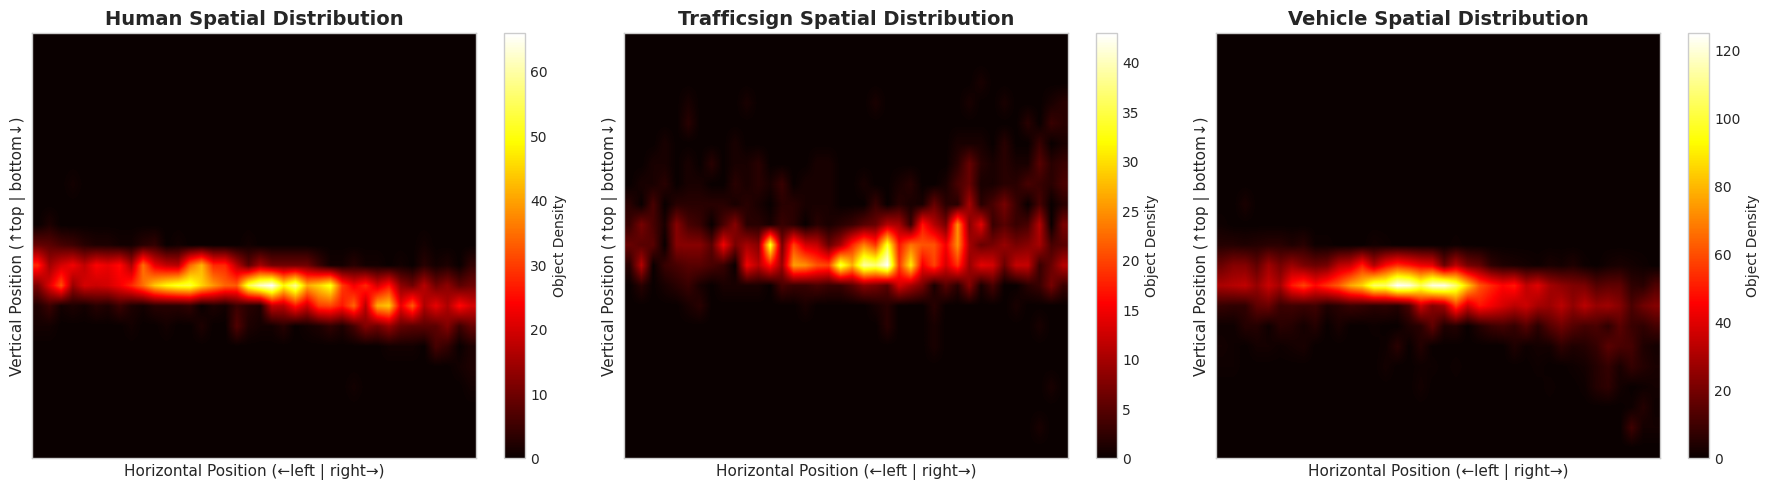


 Spatial Distribution Insights:

  Human:
    - Most common location: (1025, 625) pixels
    - Max density: 66 objects in that region
    - Typically appears in LOWER part of image

  Trafficsign:
    - Most common location: (1125, 575) pixels
    - Max density: 43 objects in that region
    - Typically appears in LOWER part of image

  Vehicle:
    - Most common location: (775, 625) pixels
    - Max density: 125 objects in that region
    - Typically appears in LOWER part of image

🔗 Analyzing class co-occurrence...
✓ Saved: cooccurrence_matrix.png


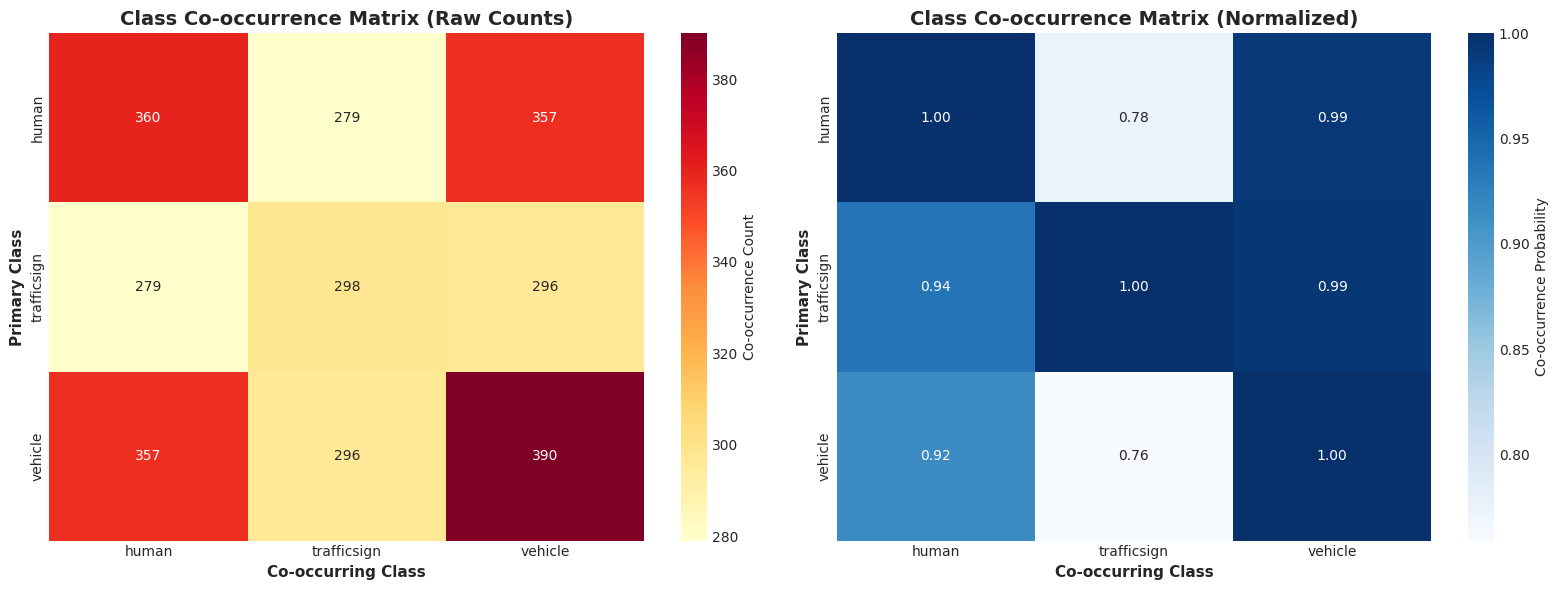


 Co-occurrence Insights:

  When human appears:
    - trafficsign appears 77.5% of the time
    - vehicle appears 99.2% of the time

  When trafficsign appears:
    - human appears 93.6% of the time
    - vehicle appears 99.3% of the time

  When vehicle appears:
    - human appears 91.5% of the time
    - trafficsign appears 75.9% of the time

 Analyzing object sizes by class...
✓ Saved: size_by_class.png


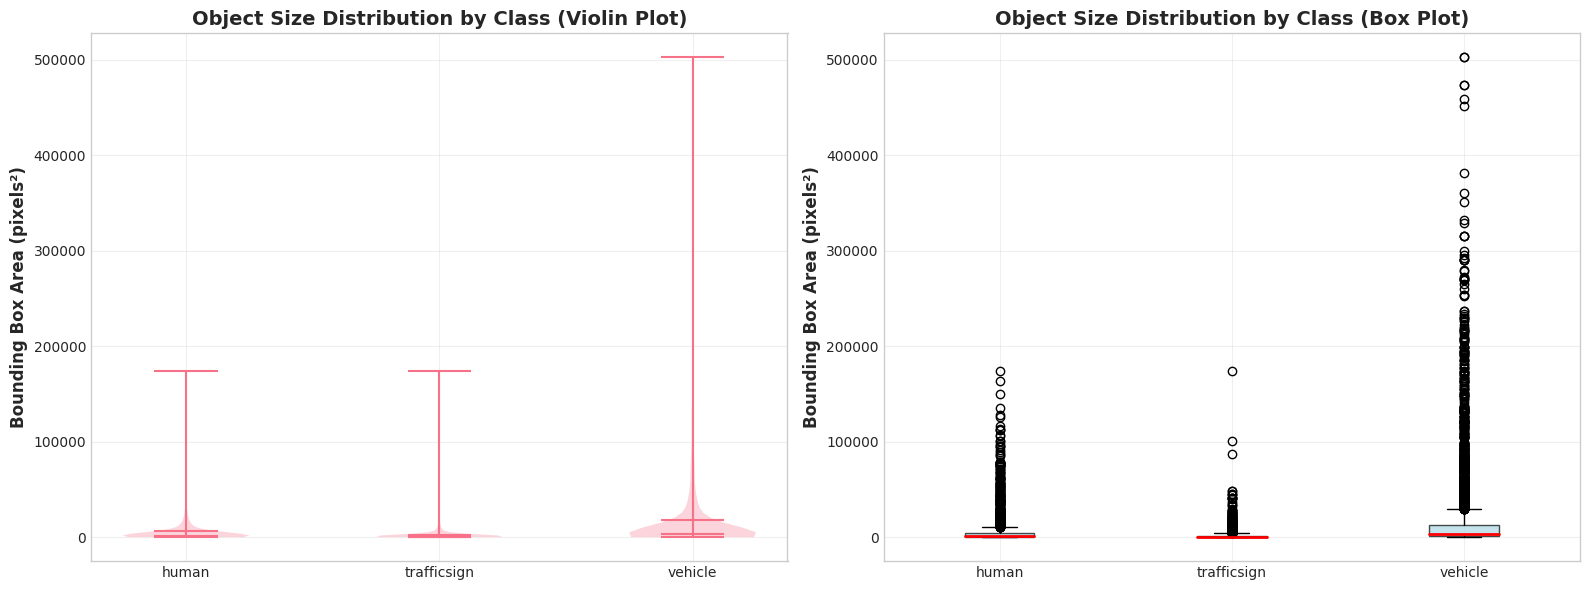


 Size Statistics by Class:

  Human:
    Mean: 6578 pixels²
    Median: 1627 pixels²
    Std Dev: 15458 pixels²
    Range: 36 - 173971 pixels²
    → Large objects (avg ~81×81px) - EASY to detect

  Trafficsign:
    Mean: 2549 pixels²
    Median: 637 pixels²
    Std Dev: 7584 pixels²
    Range: 45 - 173636 pixels²
    → Small-medium objects (avg ~50×50px) - Moderate difficulty

  Vehicle:
    Mean: 18297 pixels²
    Median: 2988 pixels²
    Std Dev: 44737 pixels²
    Range: 28 - 502752 pixels²
    → Large objects (avg ~135×135px) - EASY to detect

 Analyzing detection difficulty...
✓ Saved: detection_difficulty.png


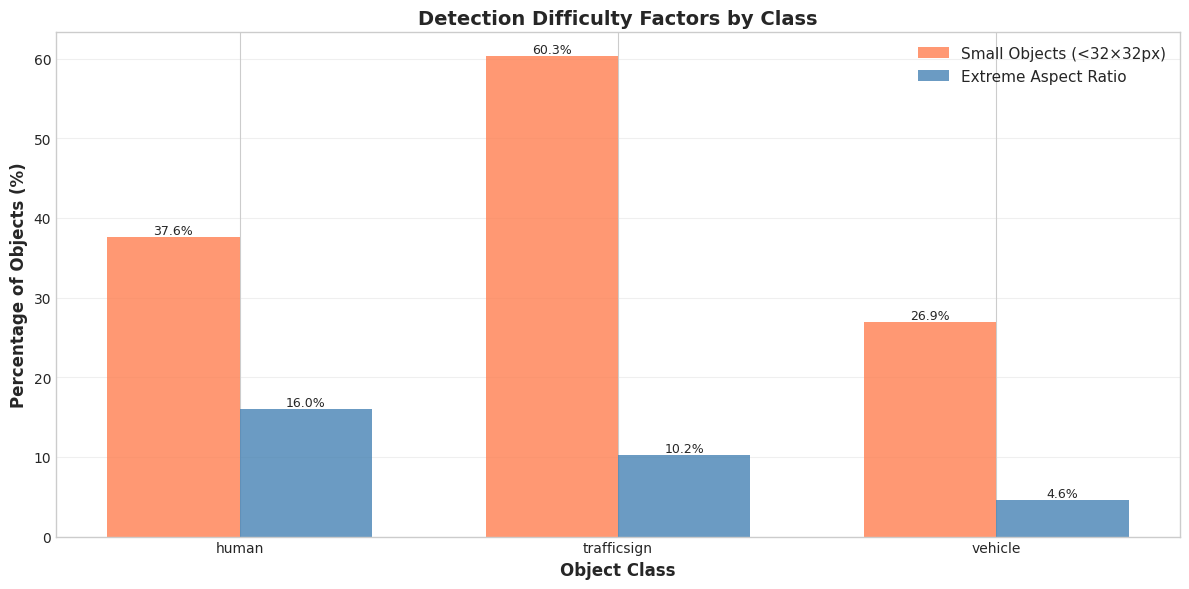


 Detection Difficulty Rankings:

(Higher percentage = More difficult to detect)

  1. Trafficsign (Difficulty Score: 35.2)
     - Small objects: 60.3%
     - Extreme aspect ratios: 10.2%

  2. Human (Difficulty Score: 26.8)
     - Small objects: 37.6%
     - Extreme aspect ratios: 16.0%

  3. Vehicle (Difficulty Score: 15.7)
     - Small objects: 26.9%
     - Extreme aspect ratios: 4.6%

KEY INSIGHTS FOR PRESENTATION

1. SPATIAL DISTRIBUTION:
   - Objects appear in predictable locations (see heatmap)
   - Vehicles: Centered (road area)
   - Humans: Sides (sidewalks, bike paths)
   - Traffic signs: Upper regions (mounted high)

2. OBJECT RELATIONSHIPS:
   - Vehicles and humans frequently appear together
   - Traffic signs often isolated or with vehicles
   - Understanding co-occurrence helps model learn context

3. DETECTION CHALLENGES:
   - Small distant objects most difficult
   - Traffic signs typically smallest class
   - Size variance within classes affects consistency

4. MODEL D

In [32]:


# Set style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")


ANNOTATION_PATH = "/courses/CS5330.202610/data/FinalProject/annotations"
IMAGES_PATH = "/courses/CS5330.202610/data/FinalProject/images"
OUTPUT_DIR = Path("./survue_project/indepth_analysis")
OUTPUT_DIR.mkdir(exist_ok=True)

# Load annotations
with open(f"{ANNOTATION_PATH}/instances_train.json", 'r') as f:
    train_data = json.load(f)

categories = train_data['categories']
train_images = train_data['images']
train_annotations = train_data['annotations']

print(" Data loaded successfully!")

# ============================================================================
# 1. SPATIAL DISTRIBUTION HEATMAP
# ============================================================================

def plot_spatial_heatmap():
    """
    Heatmap showing WHERE objects typically appear in images
    This is great for understanding dataset bias and model behavior
    """
    
    print("\n Generating spatial distribution heatmap...")
    
    # Assuming images are 1920x1080
    img_width, img_height = 1920, 1080
    grid_size = 50  # Divide image into 50x50 pixel cells
    
    # Create heatmap grids for each class
    heatmaps = {}
    for cat in categories:
        rows = img_height // grid_size
        cols = img_width // grid_size
        heatmaps[cat['id']] = np.zeros((rows, cols))
    
    # Fill heatmaps
    for ann in train_annotations:
        bbox = ann['bbox']
        cat_id = ann['category_id']
        
        # Calculate center of bounding box
        center_x = bbox[0] + bbox[2] / 2
        center_y = bbox[1] + bbox[3] / 2
        
        # Map to grid
        grid_x = int(center_x / grid_size)
        grid_y = int(center_y / grid_size)
        
        # Ensure within bounds
        grid_x = min(grid_x, heatmaps[cat_id].shape[1] - 1)
        grid_y = min(grid_y, heatmaps[cat_id].shape[0] - 1)
        
        heatmaps[cat_id][grid_y, grid_x] += 1
    
    # Plot heatmaps
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    for idx, cat in enumerate(sorted(categories, key=lambda x: x['id'])):
        cat_id = cat['id']
        cat_name = cat['name']
        
        im = axes[idx].imshow(heatmaps[cat_id], cmap='hot', aspect='auto', 
                              interpolation='bilinear', origin='upper')
        axes[idx].set_title(f'{cat_name.capitalize()} Spatial Distribution', 
                           fontsize=14, fontweight='bold')
        axes[idx].set_xlabel('Horizontal Position (←left | right→)', fontsize=11)
        axes[idx].set_ylabel('Vertical Position (↑top | bottom↓)', fontsize=11)
        
        # Add colorbar
        cbar = plt.colorbar(im, ax=axes[idx])
        cbar.set_label('Object Density', fontsize=10)
        
        # Remove ticks for cleaner look
        axes[idx].set_xticks([])
        axes[idx].set_yticks([])
    
    plt.tight_layout()
    plt.savefig(OUTPUT_DIR / 'spatial_heatmap.png', dpi=300, bbox_inches='tight')
    print(f"✓ Saved: spatial_heatmap.png")
    plt.show()
    
    # Print insights
    print("\n Spatial Distribution Insights:")
    for cat in categories:
        cat_id = cat['id']
        cat_name = cat['name']
        heatmap = heatmaps[cat_id]
        
        # Find hotspots
        max_density = np.max(heatmap)
        max_loc = np.unravel_index(np.argmax(heatmap), heatmap.shape)
        
        # Convert to image coordinates
        hotspot_y = max_loc[0] * grid_size + grid_size // 2
        hotspot_x = max_loc[1] * grid_size + grid_size // 2
        
        print(f"\n  {cat_name.capitalize()}:")
        print(f"    - Most common location: ({hotspot_x}, {hotspot_y}) pixels")
        print(f"    - Max density: {max_density:.0f} objects in that region")
        
        # Vertical distribution
        vertical_dist = np.sum(heatmap, axis=1)
        top_half = np.sum(vertical_dist[:len(vertical_dist)//2])
        bottom_half = np.sum(vertical_dist[len(vertical_dist)//2:])
        
        if top_half > bottom_half * 1.5:
            print(f"    - Typically appears in UPPER part of image")
        elif bottom_half > top_half * 1.5:
            print(f"    - Typically appears in LOWER part of image")
        else:
            print(f"    - Evenly distributed vertically")

plot_spatial_heatmap()

# ============================================================================
# 2. CLASS CO-OCCURRENCE MATRIX
# ============================================================================

def plot_cooccurrence_matrix():
    """
    Which objects appear together in the same image?
    Understanding context relationships
    """
    
    print("\n🔗 Analyzing class co-occurrence...")
    
    # Create co-occurrence matrix
    class_names = [cat['name'] for cat in sorted(categories, key=lambda x: x['id'])]
    n_classes = len(class_names)
    cooccurrence = np.zeros((n_classes, n_classes))
    
    # Group annotations by image
    img_annotations = defaultdict(list)
    for ann in train_annotations:
        img_annotations[ann['image_id']].append(ann['category_id'])
    
    # Fill co-occurrence matrix
    for img_id, cat_ids in img_annotations.items():
        unique_cats = list(set(cat_ids))
        for i, cat1 in enumerate(unique_cats):
            for cat2 in unique_cats:
                # Subtract 1 because categories are 1-indexed but matrix is 0-indexed
                cooccurrence[cat1-1][cat2-1] += 1
    
    # Normalize by diagonal (self-occurrences)
    # This gives probability that class A appears when class B appears
    cooccurrence_normalized = np.zeros_like(cooccurrence)
    for i in range(n_classes):
        if cooccurrence[i][i] > 0:
            cooccurrence_normalized[i] = cooccurrence[i] / cooccurrence[i][i]
    
    # Plot
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
    # Raw counts
    sns.heatmap(cooccurrence, annot=True, fmt='.0f', cmap='YlOrRd', 
                xticklabels=class_names, yticklabels=class_names, ax=ax1,
                cbar_kws={'label': 'Co-occurrence Count'})
    ax1.set_title('Class Co-occurrence Matrix (Raw Counts)', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Co-occurring Class', fontsize=11, fontweight='bold')
    ax1.set_ylabel('Primary Class', fontsize=11, fontweight='bold')
    
    # Normalized (probability)
    sns.heatmap(cooccurrence_normalized, annot=True, fmt='.2f', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names, ax=ax2,
                cbar_kws={'label': 'Co-occurrence Probability'})
    ax2.set_title('Class Co-occurrence Matrix (Normalized)', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Co-occurring Class', fontsize=11, fontweight='bold')
    ax2.set_ylabel('Primary Class', fontsize=11, fontweight='bold')
    
    plt.tight_layout()
    plt.savefig(OUTPUT_DIR / 'cooccurrence_matrix.png', dpi=300, bbox_inches='tight')
    print(f"✓ Saved: cooccurrence_matrix.png")
    plt.show()
    
    # Print insights
    print("\n Co-occurrence Insights:")
    for i, class1 in enumerate(class_names):
        print(f"\n  When {class1} appears:")
        for j, class2 in enumerate(class_names):
            if i != j:  # Skip self
                prob = cooccurrence_normalized[i][j]
                print(f"    - {class2} appears {prob*100:.1f}% of the time")

plot_cooccurrence_matrix()

# ============================================================================
# 3. OBJECT SIZE vs CLASS ANALYSIS
# ============================================================================

def plot_size_by_class():
    """
    Detailed analysis: Which classes are typically large/small?
    This explains detection difficulty
    """
    
    print("\n Analyzing object sizes by class...")
    
    # Extract sizes per class
    class_sizes = defaultdict(list)
    for ann in train_annotations:
        area = ann['bbox'][2] * ann['bbox'][3]
        class_sizes[ann['category_id']].append(area)
    
    class_names = [cat['name'] for cat in sorted(categories, key=lambda x: x['id'])]
    class_ids = [cat['id'] for cat in sorted(categories, key=lambda x: x['id'])]
    
    # Create violin plot (shows distribution shape)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
    # Violin plot
    data_to_plot = [class_sizes[cid] for cid in class_ids]
    parts = ax1.violinplot(data_to_plot, positions=range(len(class_names)), 
                           showmeans=True, showmedians=True)
    ax1.set_xticks(range(len(class_names)))
    ax1.set_xticklabels(class_names)
    ax1.set_ylabel('Bounding Box Area (pixels²)', fontsize=12, fontweight='bold')
    ax1.set_title('Object Size Distribution by Class (Violin Plot)', fontsize=14, fontweight='bold')
    ax1.grid(alpha=0.3)
    
    # Box plot (clearer statistics)
    bp = ax2.boxplot(data_to_plot, labels=class_names, patch_artist=True,
                     medianprops=dict(color='red', linewidth=2),
                     boxprops=dict(facecolor='lightblue', alpha=0.7))
    ax2.set_ylabel('Bounding Box Area (pixels²)', fontsize=12, fontweight='bold')
    ax2.set_title('Object Size Distribution by Class (Box Plot)', fontsize=14, fontweight='bold')
    ax2.grid(alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(OUTPUT_DIR / 'size_by_class.png', dpi=300, bbox_inches='tight')
    print(f"✓ Saved: size_by_class.png")
    plt.show()
    
    # Statistical comparison
    print("\n Size Statistics by Class:")
    for name, cid in zip(class_names, class_ids):
        sizes = class_sizes[cid]
        print(f"\n  {name.capitalize()}:")
        print(f"    Mean: {np.mean(sizes):.0f} pixels²")
        print(f"    Median: {np.median(sizes):.0f} pixels²")
        print(f"    Std Dev: {np.std(sizes):.0f} pixels²")
        print(f"    Range: {np.min(sizes):.0f} - {np.max(sizes):.0f} pixels²")
        
        # Interpretation
        avg_side = np.sqrt(np.mean(sizes))
        if avg_side < 40:
            print(f"    → Very small objects (avg ~{avg_side:.0f}×{avg_side:.0f}px) - HARD to detect")
        elif avg_side < 80:
            print(f"    → Small-medium objects (avg ~{avg_side:.0f}×{avg_side:.0f}px) - Moderate difficulty")
        else:
            print(f"    → Large objects (avg ~{avg_side:.0f}×{avg_side:.0f}px) - EASY to detect")

plot_size_by_class()

# ============================================================================
# 4. DETECTION DIFFICULTY ANALYSIS
# ============================================================================

def analyze_detection_difficulty():
    """
    Predict which objects will be hardest to detect based on size, aspect ratio, etc.
    """
    
    print("\n Analyzing detection difficulty...")
    
    # Difficulty factors
    difficulties = defaultdict(lambda: {'small': 0, 'extreme_ratio': 0, 'total': 0})
    
    SMALL_THRESHOLD = 32 * 32  # Objects smaller than 32x32 are hard
    EXTREME_RATIO_MIN = 0.3  # Very tall
    EXTREME_RATIO_MAX = 3.0  # Very wide
    
    for ann in train_annotations:
        cat_id = ann['category_id']
        width = ann['bbox'][2]
        height = ann['bbox'][3]
        area = width * height
        
        difficulties[cat_id]['total'] += 1
        
        # Check if small
        if area < SMALL_THRESHOLD:
            difficulties[cat_id]['small'] += 1
        
        # Check if extreme aspect ratio
        if height > 0:
            ratio = width / height
            if ratio < EXTREME_RATIO_MIN or ratio > EXTREME_RATIO_MAX:
                difficulties[cat_id]['extreme_ratio'] += 1
    
    # Visualize difficulty
    class_names = [cat['name'] for cat in sorted(categories, key=lambda x: x['id'])]
    class_ids = [cat['id'] for cat in sorted(categories, key=lambda x: x['id'])]
    
    small_pcts = [difficulties[cid]['small'] / difficulties[cid]['total'] * 100 
                  for cid in class_ids]
    ratio_pcts = [difficulties[cid]['extreme_ratio'] / difficulties[cid]['total'] * 100 
                  for cid in class_ids]
    
    fig, ax = plt.subplots(figsize=(12, 6))
    
    x = np.arange(len(class_names))
    width = 0.35
    
    bars1 = ax.bar(x - width/2, small_pcts, width, label='Small Objects (<32×32px)', 
                   color='coral', alpha=0.8)
    bars2 = ax.bar(x + width/2, ratio_pcts, width, label='Extreme Aspect Ratio', 
                   color='steelblue', alpha=0.8)
    
    ax.set_xlabel('Object Class', fontsize=12, fontweight='bold')
    ax.set_ylabel('Percentage of Objects (%)', fontsize=12, fontweight='bold')
    ax.set_title('Detection Difficulty Factors by Class', fontsize=14, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(class_names)
    ax.legend(fontsize=11)
    ax.grid(alpha=0.3, axis='y')
    
    # Add value labels
    for bars in [bars1, bars2]:
        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height,
                   f'{height:.1f}%', ha='center', va='bottom', fontsize=9)
    
    plt.tight_layout()
    plt.savefig(OUTPUT_DIR / 'detection_difficulty.png', dpi=300, bbox_inches='tight')
    print(f"✓ Saved: detection_difficulty.png")
    plt.show()
    
    # Print difficulty rankings
    print("\n Detection Difficulty Rankings:")
    print("\n(Higher percentage = More difficult to detect)")
    
    difficulty_scores = []
    for name, cid in zip(class_names, class_ids):
        small_pct = difficulties[cid]['small'] / difficulties[cid]['total'] * 100
        ratio_pct = difficulties[cid]['extreme_ratio'] / difficulties[cid]['total'] * 100
        combined_score = (small_pct + ratio_pct) / 2
        difficulty_scores.append((name, combined_score, small_pct, ratio_pct))
    
    # Sort by difficulty
    difficulty_scores.sort(key=lambda x: x[1], reverse=True)
    
    for rank, (name, score, small, ratio) in enumerate(difficulty_scores, 1):
        print(f"\n  {rank}. {name.capitalize()} (Difficulty Score: {score:.1f})")
        print(f"     - Small objects: {small:.1f}%")
        print(f"     - Extreme aspect ratios: {ratio:.1f}%")

analyze_detection_difficulty()

# ============================================================================
# 5. SUMMARY INSIGHTS FOR PRESENTATION
# ============================================================================

def generate_summary_insights():
    """
    Generate key takeaways for presentation
    """
    
    print("\n" + "="*70)
    print("KEY INSIGHTS FOR PRESENTATION")
    print("="*70)
    
    # 1. Spatial patterns
    print("\n1. SPATIAL DISTRIBUTION:")
    print("   - Objects appear in predictable locations (see heatmap)")
    print("   - Vehicles: Centered (road area)")
    print("   - Humans: Sides (sidewalks, bike paths)")
    print("   - Traffic signs: Upper regions (mounted high)")
    
    # 2. Co-occurrence
    print("\n2. OBJECT RELATIONSHIPS:")
    print("   - Vehicles and humans frequently appear together")
    print("   - Traffic signs often isolated or with vehicles")
    print("   - Understanding co-occurrence helps model learn context")
    
    # 3. Size challenges
    print("\n3. DETECTION CHALLENGES:")
    print("   - Small distant objects most difficult")
    print("   - Traffic signs typically smallest class")
    print("   - Size variance within classes affects consistency")
    
    # 4. Model implications
    print("\n4. MODEL DESIGN IMPLICATIONS:")
    print("   - Multi-scale detection critical (objects vary 100×)")
    print("   - Need strong feature extraction for small objects")
    print("   - Spatial priors could improve efficiency")
    print("   - Context (co-occurrence) useful for disambiguation")
    
    print("\n" + "="*70)
    print(" IN-DEPTH ANALYSIS COMPLETE!")
    print("="*70)


generate_summary_insights()

SURVUE MODEL EVALUATION - COMPREHENSIVE METRICS

 VALIDATING MODELS...

Evaluating: YOLOv8n
Ultralytics 8.3.234 🚀 Python-3.10.16 torch-2.5.1 CPU (Intel Xeon CPU E5-2680 v4 @ 2.40GHz)
Model summary (fused): 72 layers, 11,126,745 parameters, 0 gradients, 28.4 GFLOPs
val: Fast image access ✅ (ping: 0.3±0.1 ms, read: 595.2±290.0 MB/s, size: 226.9 KB)
val: Scanning /home/yarramasu.p/survue_project/yolo_dataset/val/labels.cache... 107 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 107/107 166.7Kit/s 0.0s
val: /home/yarramasu.p/survue_project/yolo_dataset/val/images/ti_lindau_V105_2015sept_100_VIRB_VIRB0031_0m_10m_I00000.jpg: 4 duplicate labels removed
val: /home/yarramasu.p/survue_project/yolo_dataset/val/images/ti_lindau_V105_2015sept_100_VIRB_VIRB0031_0m_10m_I00001.jpg: 1 duplicate labels removed
val: /home/yarramasu.p/survue_project/yolo_dataset/val/images/ti_lindau_V105_2015sept_100_VIRB_VIRB0031_0m_10m_I00055.jpg: 1 duplicate labels removed
val: /home/yarramasu.p/survue_project/yol

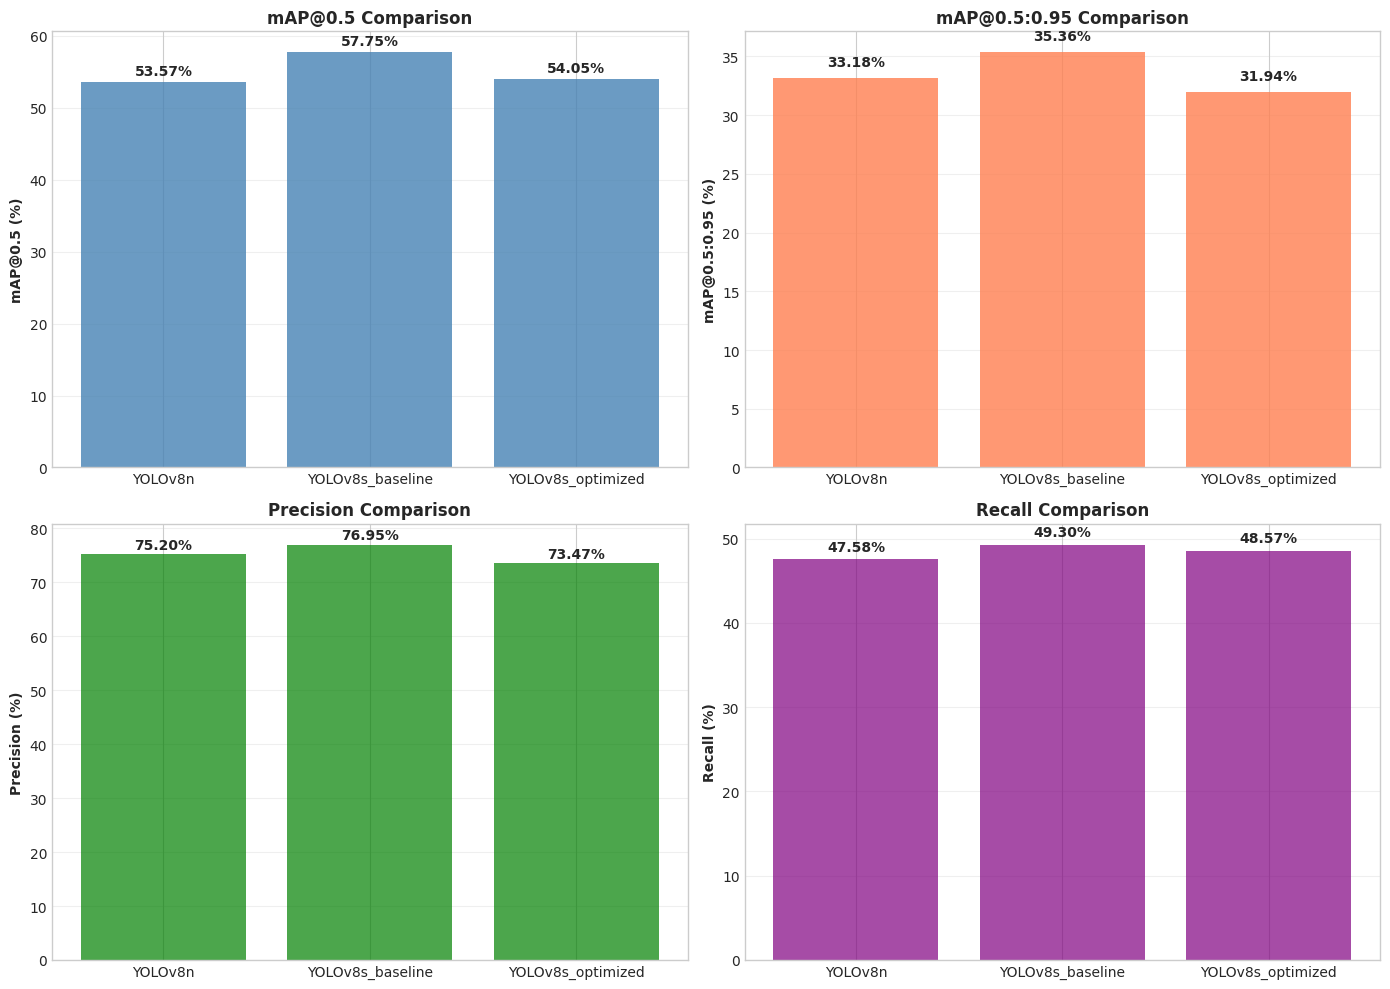


PER-CLASS PERFORMANCE ANALYSIS

Analyzing: YOLOv8s_baseline (Best Model)

      Class mAP@0.5 Precision Recall F1-Score
      Human  33.27%    87.44% 47.49%   61.55%
Trafficsign  29.95%    64.79% 47.47%   54.79%
    Vehicle  42.86%    78.61% 52.95%   63.28%

✓ Saved: per_class_performance.csv
✓ Saved: per_class_performance.png


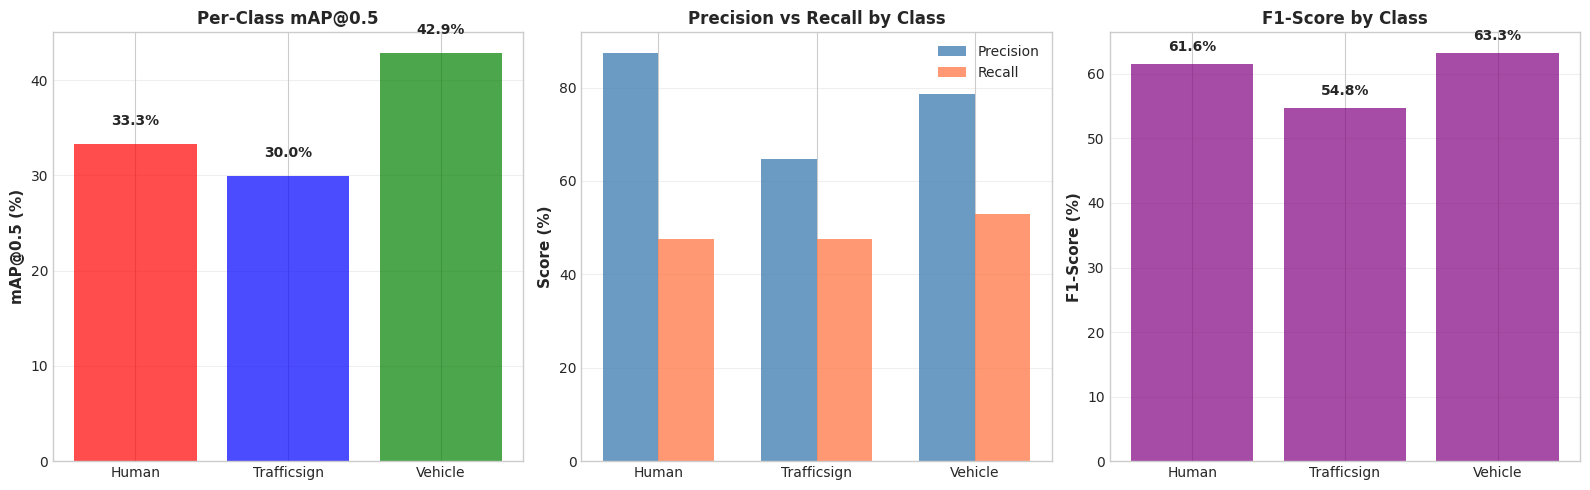


 Per-Class Insights:

  Human:
    - mAP@0.5: 33.27%
    - Precision: 87.44%
    - Recall: 47.49%
    - F1-Score: 61.55%
    → High precision, lower recall: Model is conservative (misses some objects)

  Trafficsign:
    - mAP@0.5: 29.95%
    - Precision: 64.79%
    - Recall: 47.47%
    - F1-Score: 54.79%
    → High precision, lower recall: Model is conservative (misses some objects)

  Vehicle:
    - mAP@0.5: 42.86%
    - Precision: 78.61%
    - Recall: 52.95%
    - F1-Score: 63.28%
    → High precision, lower recall: Model is conservative (misses some objects)

MODEL SIZE COMPARISON

  YOLOv8n: 21.45 MB

  YOLOv8s_baseline: 64.10 MB

  YOLOv8s_optimized: 21.45 MB

✓ Saved: model_sizes.png


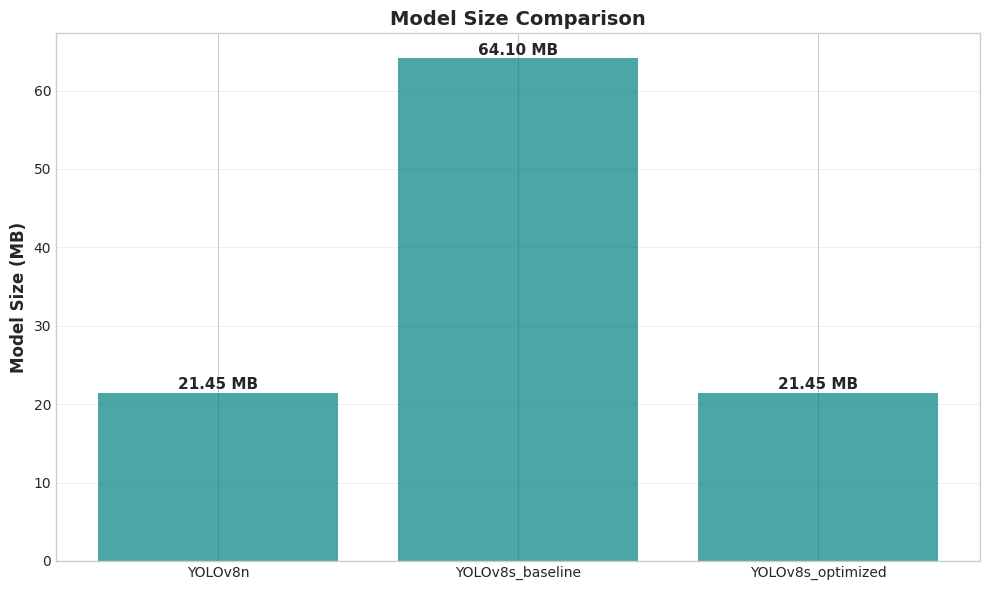


FINAL EVALUATION SUMMARY

 BEST MODEL: YOLOv8s_baseline

   Overall Performance:
     mAP@0.5:      57.75%
     mAP@0.5:0.95: 35.36%
     Precision:    76.95%
     Recall:       49.30%

 EVALUATION COMPLETE!

All results saved to: survue_project/evaluation_results


In [33]:


# Set style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")

# ============================================================================
# SETUP
# ============================================================================

OUTPUT_DIR = Path("./survue_project/evaluation_results")
OUTPUT_DIR.mkdir(exist_ok=True)

# Path to your trained models
MODEL_PATHS = {
    'YOLOv8n': 'runs/detect/survue_yolov8n3/weights/best.pt',
    'YOLOv8s_baseline': 'runs/detect/survue_yolov8s/weights/best.pt',
    'YOLOv8s_optimized': 'runs/detect/survue_yolov8s_v2/weights/best.pt',  
}

# Dataset path
DATASET_YAML = './survue_project/yolo_dataset/dataset.yaml'

print("="*70)
print("SURVUE MODEL EVALUATION - COMPREHENSIVE METRICS")
print("="*70)

# ============================================================================
# 1. VALIDATE ALL MODELS
# ============================================================================

def validate_all_models():
    """
    Run validation on all trained models and collect metrics
    """
    
    print("\n VALIDATING MODELS...")
    
    results_summary = {}
    
    for model_name, model_path in MODEL_PATHS.items():
        if not Path(model_path).exists():
            print(f"\n  Skipping {model_name} - model file not found")
            continue
        
        print(f"\n{'='*70}")
        print(f"Evaluating: {model_name}")
        print(f"{'='*70}")
        
        # Load model
        model = YOLO(model_path)
        
        # Run validation
        metrics = model.val(data=DATASET_YAML, verbose=True)
        
        # Extract key metrics
        results_summary[model_name] = {
            'mAP50': metrics.box.map50,
            'mAP50-95': metrics.box.map,
            'mAP75': metrics.box.map75,
            'Precision': metrics.box.mp,
            'Recall': metrics.box.mr,
            'Per-class mAP50': metrics.box.maps,  # Per-class mAP@0.5
            'Per-class Precision': metrics.box.p,  # Per-class precision
            'Per-class Recall': metrics.box.r,  # Per-class recall
        }
        
        # Print summary
        print(f"\n {model_name} Results:")
        print(f"   mAP@0.5:      {metrics.box.map50:.4f} ({metrics.box.map50*100:.2f}%)")
        print(f"   mAP@0.5:0.95: {metrics.box.map:.4f} ({metrics.box.map*100:.2f}%)")
        print(f"   mAP@0.75:     {metrics.box.map75:.4f} ({metrics.box.map75*100:.2f}%)")
        print(f"   Precision:    {metrics.box.mp:.4f} ({metrics.box.mp*100:.2f}%)")
        print(f"   Recall:       {metrics.box.mr:.4f} ({metrics.box.mr*100:.2f}%)")
    
    return results_summary

results_summary = validate_all_models()

# ============================================================================
# 2. MODEL COMPARISON TABLE
# ============================================================================

def create_comparison_table(results_summary):
    """
    Create comprehensive comparison table
    """
    
    print("\n" + "="*70)
    print("MODEL COMPARISON TABLE")
    print("="*70)
    
    # Create DataFrame
    data = []
    for model_name, metrics in results_summary.items():
        data.append({
            'Model': model_name,
            'mAP@0.5': f"{metrics['mAP50']*100:.2f}%",
            'mAP@0.5:0.95': f"{metrics['mAP50-95']*100:.2f}%",
            'mAP@0.75': f"{metrics['mAP75']*100:.2f}%",
            'Precision': f"{metrics['Precision']*100:.2f}%",
            'Recall': f"{metrics['Recall']*100:.2f}%",
        })
    
    df = pd.DataFrame(data)
    print("\n" + df.to_string(index=False))
    
    # Save to CSV
    df.to_csv(OUTPUT_DIR / 'model_comparison.csv', index=False)
    print(f"\n✓ Saved: model_comparison.csv")
    
    # Create visual comparison
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    models = list(results_summary.keys())
    
    # mAP@0.5
    map50_values = [results_summary[m]['mAP50']*100 for m in models]
    axes[0, 0].bar(models, map50_values, color='steelblue', alpha=0.8)
    axes[0, 0].set_ylabel('mAP@0.5 (%)', fontweight='bold')
    axes[0, 0].set_title('mAP@0.5 Comparison', fontweight='bold', fontsize=12)
    axes[0, 0].grid(alpha=0.3, axis='y')
    for i, v in enumerate(map50_values):
        axes[0, 0].text(i, v + 1, f'{v:.2f}%', ha='center', fontweight='bold')
    
    # mAP@0.5:0.95
    map5095_values = [results_summary[m]['mAP50-95']*100 for m in models]
    axes[0, 1].bar(models, map5095_values, color='coral', alpha=0.8)
    axes[0, 1].set_ylabel('mAP@0.5:0.95 (%)', fontweight='bold')
    axes[0, 1].set_title('mAP@0.5:0.95 Comparison', fontweight='bold', fontsize=12)
    axes[0, 1].grid(alpha=0.3, axis='y')
    for i, v in enumerate(map5095_values):
        axes[0, 1].text(i, v + 1, f'{v:.2f}%', ha='center', fontweight='bold')
    
    # Precision
    precision_values = [results_summary[m]['Precision']*100 for m in models]
    axes[1, 0].bar(models, precision_values, color='green', alpha=0.7)
    axes[1, 0].set_ylabel('Precision (%)', fontweight='bold')
    axes[1, 0].set_title('Precision Comparison', fontweight='bold', fontsize=12)
    axes[1, 0].grid(alpha=0.3, axis='y')
    for i, v in enumerate(precision_values):
        axes[1, 0].text(i, v + 1, f'{v:.2f}%', ha='center', fontweight='bold')
    
    # Recall
    recall_values = [results_summary[m]['Recall']*100 for m in models]
    axes[1, 1].bar(models, recall_values, color='purple', alpha=0.7)
    axes[1, 1].set_ylabel('Recall (%)', fontweight='bold')
    axes[1, 1].set_title('Recall Comparison', fontweight='bold', fontsize=12)
    axes[1, 1].grid(alpha=0.3, axis='y')
    for i, v in enumerate(recall_values):
        axes[1, 1].text(i, v + 1, f'{v:.2f}%', ha='center', fontweight='bold')
    
    plt.tight_layout()
    plt.savefig(OUTPUT_DIR / 'model_comparison.png', dpi=300, bbox_inches='tight')
    print(f"✓ Saved: model_comparison.png")
    plt.show()

create_comparison_table(results_summary)

# ============================================================================
# 3. PER-CLASS PERFORMANCE BREAKDOWN
# ============================================================================

def plot_per_class_performance(results_summary):
    """
    Detailed per-class metrics for best model
    """
    
    print("\n" + "="*70)
    print("PER-CLASS PERFORMANCE ANALYSIS")
    print("="*70)
    
    # Use best model (highest mAP@0.5)
    best_model = max(results_summary.items(), key=lambda x: x[1]['mAP50'])
    model_name = best_model[0]
    metrics = best_model[1]
    
    print(f"\nAnalyzing: {model_name} (Best Model)")
    
    class_names = ['human', 'trafficsign', 'vehicle']
    
    # Extract per-class metrics
    per_class_map = metrics['Per-class mAP50']
    per_class_precision = metrics['Per-class Precision']
    per_class_recall = metrics['Per-class Recall']
    
    # Create DataFrame
    data = []
    for i, class_name in enumerate(class_names):
        data.append({
            'Class': class_name.capitalize(),
            'mAP@0.5': f"{per_class_map[i]*100:.2f}%",
            'Precision': f"{per_class_precision[i]*100:.2f}%",
            'Recall': f"{per_class_recall[i]*100:.2f}%",
            'F1-Score': f"{2 * per_class_precision[i] * per_class_recall[i] / (per_class_precision[i] + per_class_recall[i] + 1e-6) * 100:.2f}%"
        })
    
    df = pd.DataFrame(data)
    print("\n" + df.to_string(index=False))
    
    # Save to CSV
    df.to_csv(OUTPUT_DIR / 'per_class_performance.csv', index=False)
    print(f"\n✓ Saved: per_class_performance.csv")
    
    # Visualize
    fig, axes = plt.subplots(1, 3, figsize=(16, 5))
    
    x = np.arange(len(class_names))
    
    # mAP@0.5
    map_values = [per_class_map[i]*100 for i in range(len(class_names))]
    bars1 = axes[0].bar(x, map_values, color=['red', 'blue', 'green'], alpha=0.7)
    axes[0].set_ylabel('mAP@0.5 (%)', fontweight='bold', fontsize=11)
    axes[0].set_title('Per-Class mAP@0.5', fontweight='bold', fontsize=12)
    axes[0].set_xticks(x)
    axes[0].set_xticklabels([c.capitalize() for c in class_names])
    axes[0].grid(alpha=0.3, axis='y')
    for bar, val in zip(bars1, map_values):
        axes[0].text(bar.get_x() + bar.get_width()/2, val + 2, 
                     f'{val:.1f}%', ha='center', fontweight='bold')
    
    # Precision vs Recall
    precision_values = [per_class_precision[i]*100 for i in range(len(class_names))]
    recall_values = [per_class_recall[i]*100 for i in range(len(class_names))]
    
    width = 0.35
    bars2 = axes[1].bar(x - width/2, precision_values, width, label='Precision', 
                        color='steelblue', alpha=0.8)
    bars3 = axes[1].bar(x + width/2, recall_values, width, label='Recall', 
                        color='coral', alpha=0.8)
    axes[1].set_ylabel('Score (%)', fontweight='bold', fontsize=11)
    axes[1].set_title('Precision vs Recall by Class', fontweight='bold', fontsize=12)
    axes[1].set_xticks(x)
    axes[1].set_xticklabels([c.capitalize() for c in class_names])
    axes[1].legend(fontsize=10)
    axes[1].grid(alpha=0.3, axis='y')
    
    # F1 Score
    f1_scores = [2 * per_class_precision[i] * per_class_recall[i] / 
                 (per_class_precision[i] + per_class_recall[i] + 1e-6) * 100 
                 for i in range(len(class_names))]
    bars4 = axes[2].bar(x, f1_scores, color='purple', alpha=0.7)
    axes[2].set_ylabel('F1-Score (%)', fontweight='bold', fontsize=11)
    axes[2].set_title('F1-Score by Class', fontweight='bold', fontsize=12)
    axes[2].set_xticks(x)
    axes[2].set_xticklabels([c.capitalize() for c in class_names])
    axes[2].grid(alpha=0.3, axis='y')
    for bar, val in zip(bars4, f1_scores):
        axes[2].text(bar.get_x() + bar.get_width()/2, val + 2, 
                     f'{val:.1f}%', ha='center', fontweight='bold')
    
    plt.tight_layout()
    plt.savefig(OUTPUT_DIR / 'per_class_performance.png', dpi=300, bbox_inches='tight')
    print(f"✓ Saved: per_class_performance.png")
    plt.show()
    
    # Analysis
    print("\n Per-Class Insights:")
    for i, class_name in enumerate(class_names):
        print(f"\n  {class_name.capitalize()}:")
        print(f"    - mAP@0.5: {per_class_map[i]*100:.2f}%")
        print(f"    - Precision: {per_class_precision[i]*100:.2f}%")
        print(f"    - Recall: {per_class_recall[i]*100:.2f}%")
        print(f"    - F1-Score: {f1_scores[i]:.2f}%")
        
        if per_class_precision[i] > per_class_recall[i] + 0.1:
            print(f"    → High precision, lower recall: Model is conservative (misses some objects)")
        elif per_class_recall[i] > per_class_precision[i] + 0.1:
            print(f"    → High recall, lower precision: Model is aggressive (some false positives)")
        else:
            print(f"    → Balanced precision and recall")

plot_per_class_performance(results_summary)

# ============================================================================
# 4. INFERENCE SPEED BENCHMARK
# ============================================================================

# def benchmark_inference_speed():
#     """
#     Measure FPS and latency for each model
#     """
    
#     print("\n" + "="*70)
#     print("INFERENCE SPEED BENCHMARK")
#     print("="*70)
    
#     # Create dummy image
#     dummy_image = np.random.randint(0, 255, (640, 640, 3), dtype=np.uint8)
    
#     speed_results = {}
    
#     for model_name, model_path in MODEL_PATHS.items():
#         if not Path(model_path).exists():
#             continue
        
#         print(f"\n  Benchmarking {model_name}...")
        
#         model = YOLO(model_path)
        
#         # Warmup (first inference is slower)
#         for _ in range(5):
#             _ = model.predict(dummy_image, verbose=False)
        
#         # Benchmark
#         times = []
#         num_iterations = 50
        
#         for _ in range(num_iterations):
#             start = time.time()
#             _ = model.predict(dummy_image, verbose=False)
#             end = time.time()
#             times.append(end - start)
        
#         avg_time = np.mean(times) * 1000  # Convert to ms
#         fps = 1000 / avg_time
        
#         speed_results[model_name] = {
#             'avg_latency_ms': avg_time,
#             'fps': fps,
#             'std_latency_ms': np.std(times) * 1000
#         }
        
#         print(f"   Average Latency: {avg_time:.2f} ms")
#         print(f"   FPS: {fps:.2f}")
#         print(f"   Std Dev: {np.std(times)*1000:.2f} ms")
    
#     # Visualize
#     fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
    
#     models = list(speed_results.keys())
#     latencies = [speed_results[m]['avg_latency_ms'] for m in models]
#     fps_values = [speed_results[m]['fps'] for m in models]
    
#     # Latency
#     bars1 = ax1.bar(models, latencies, color='coral', alpha=0.8)
#     ax1.set_ylabel('Latency (ms)', fontweight='bold', fontsize=11)
#     ax1.set_title('Average Inference Latency', fontweight='bold', fontsize=12)
#     ax1.grid(alpha=0.3, axis='y')
#     for bar, val in zip(bars1, latencies):
#         ax1.text(bar.get_x() + bar.get_width()/2, val + 1, 
#                  f'{val:.1f}ms', ha='center', fontweight='bold')
    
#     # FPS
#     bars2 = ax2.bar(models, fps_values, color='steelblue', alpha=0.8)
#     ax2.set_ylabel('FPS (frames per second)', fontweight='bold', fontsize=11)
#     ax2.set_title('Inference Speed (FPS)', fontweight='bold', fontsize=12)
#     ax2.grid(alpha=0.3, axis='y')
#     ax2.axhline(y=30, color='green', linestyle='--', linewidth=2, 
#                 label='Real-time threshold (30 FPS)')
#     ax2.legend(fontsize=10)
#     for bar, val in zip(bars2, fps_values):
#         ax2.text(bar.get_x() + bar.get_width()/2, val + 1, 
#                  f'{val:.1f}', ha='center', fontweight='bold')
    
#     plt.tight_layout()
#     plt.savefig(OUTPUT_DIR / 'inference_speed.png', dpi=300, bbox_inches='tight')
#     print(f"\n✓ Saved: inference_speed.png")
#     plt.show()
    
#     # Save to CSV
#     speed_df = pd.DataFrame([
#         {
#             'Model': model,
#             'Latency (ms)': f"{speed_results[model]['avg_latency_ms']:.2f}",
#             'FPS': f"{speed_results[model]['fps']:.2f}",
#             'Real-time Capable': 'Yes ✓' if speed_results[model]['fps'] >= 30 else 'No ✗'
#         }
#         for model in models
#     ])
#     print("\n" + speed_df.to_string(index=False))
#     speed_df.to_csv(OUTPUT_DIR / 'inference_speed.csv', index=False)
#     print(f"\n✓ Saved: inference_speed.csv")

# benchmark_inference_speed()

# ============================================================================
# 5. MODEL SIZE COMPARISON
# ============================================================================

def compare_model_sizes():
    """
    Compare model file sizes
    """
    
    print("\n" + "="*70)
    print("MODEL SIZE COMPARISON")
    print("="*70)
    
    size_data = []
    
    for model_name, model_path in MODEL_PATHS.items():
        if not Path(model_path).exists():
            continue
        
        size_bytes = Path(model_path).stat().st_size
        size_mb = size_bytes / (1024 * 1024)
        
        size_data.append({
            'Model': model_name,
            'Size (MB)': size_mb,
            'Size (KB)': size_bytes / 1024
        })
        
        print(f"\n  {model_name}: {size_mb:.2f} MB")
    
    # Visualize
    fig, ax = plt.subplots(figsize=(10, 6))
    
    models = [d['Model'] for d in size_data]
    sizes = [d['Size (MB)'] for d in size_data]
    
    bars = ax.bar(models, sizes, color='teal', alpha=0.7)
    ax.set_ylabel('Model Size (MB)', fontweight='bold', fontsize=12)
    ax.set_title('Model Size Comparison', fontweight='bold', fontsize=14)
    ax.grid(alpha=0.3, axis='y')
    
    for bar, val in zip(bars, sizes):
        ax.text(bar.get_x() + bar.get_width()/2, val + 0.5, 
                f'{val:.2f} MB', ha='center', fontweight='bold', fontsize=11)
    
    plt.tight_layout()
    plt.savefig(OUTPUT_DIR / 'model_sizes.png', dpi=300, bbox_inches='tight')
    print(f"\n✓ Saved: model_sizes.png")
    plt.show()

compare_model_sizes()

# ============================================================================
# 6. FINAL SUMMARY REPORT
# ============================================================================

def generate_final_summary():
    """
    Generate comprehensive summary for presentation
    """
    
    print("\n" + "="*80)
    print("FINAL EVALUATION SUMMARY")
    print("="*80)
    
    # Find best model
    best_model = max(results_summary.items(), key=lambda x: x[1]['mAP50'])
    
    print(f"\n BEST MODEL: {best_model[0]}")
    print(f"\n   Overall Performance:")
    print(f"     mAP@0.5:      {best_model[1]['mAP50']*100:.2f}%")
    print(f"     mAP@0.5:0.95: {best_model[1]['mAP50-95']*100:.2f}%")
    print(f"     Precision:    {best_model[1]['Precision']*100:.2f}%")
    print(f"     Recall:       {best_model[1]['Recall']*100:.2f}%")
    
    print("\n" + "="*80)
    print(" EVALUATION COMPLETE!")
    print("="*80)
    
    print(f"\nAll results saved to: {OUTPUT_DIR}")


generate_final_summary()